# Predicting Cancer Survival Months Based on Diagnosis Data

In this notebook, we use Surveillance, Epidemiology, and End Results (SEER) Incidence Data to predict the chance of survival given cancer diagnosis information obtained when the patient is diagnosed with cancer. We find answers to two questions:

**Question 1: Given the demographic and diagnosis information, can we predict if the patient will pass away due to complications caused by the diagnosed cancer?**

**Question 2: For patients who eventually pass away due to cancer, can we predict the number of months they expect to survive?**

## Import Libraries and Load Dataset

In [106]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")
pd.options.display.max_columns = None

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.metrics import auc


from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report



import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input, Embedding, BatchNormalization, Dense, Dropout, Flatten, Concatenate, concatenate, SpatialDropout1D
from tensorflow.keras.models import Model
from keras.utils.vis_utils import plot_model

import pickle


import matplotlib.pyplot as plt
plt.rcParams["figure.dpi"] = 500

%matplotlib inline

In [107]:
# Read the dataset 
df = pd.read_csv('case_reduced_label_revised.csv')
df.head()

Age recode with <1 year olds     Sex  Year of diagnosis  \
0                  40-44 years    Male               2002   
1                  65-69 years    Male               2000   
2                  35-39 years  Female               2008   
3                  60-64 years  Female               2008   
4                    85+ years    Male               2008   

  Race recode (W, B, AI, API) Origin recode NHIA (Hispanic, Non-Hisp)  \
0                       White             Non-Spanish-Hispanic-Latino   
1                       White             Non-Spanish-Hispanic-Latino   
2                       White                 Spanish-Hispanic-Latino   
3                       White             Non-Spanish-Hispanic-Latino   
4                       White             Non-Spanish-Hispanic-Latino   

                        Site recode ICD-O-3/WHO 2008 Behavior code ICD-O-3  \
0                                             Testis             Malignant   
1                                             Rectum             Malignant   
2                              Rectosigmoid Junction             Malignant   
3  Trachea, Mediastinum and Other Respiratory Organs             Malignant   
4                               Melanoma of the Skin             Malignant   

                     Grade (thru 2017) Grade Clinical (2018+)  \
0                              Unknown               Blank(s)   
1         Well differentiated; Grade I               Blank(s)   
2  Moderately differentiated; Grade II               Blank(s)   
3         Well differentiated; Grade I               Blank(s)   
4                              Unknown               Blank(s)   

  Grade Pathological (2018+)                Laterality  \
0                   Blank(s)  Left - origin of primary   
1                   Blank(s)        Not a paired  site   
2                   Blank(s)        Not a paired  site   
3                   Blank(s)        Not a paired  site   
4                   Blank(s)        Not a paired  site   

  Diagnostic Confirmation SEER Combined Summary Stage 2000 (2004-2017)  \
0      Positive histology                                     Blank(s)   
1      Positive histology                                     Blank(s)   
2      Positive histology             Distant site(s)/node(s) involved   
3      Positive histology                               Localized only   
4      Positive histology                               Localized only   

  Derived AJCC Stage Group, 6th ed (2004-2015)  \
0                                     Blank(s)   
1                                     Blank(s)   
2                                           IV   
3                                           IB   
4                                           IB   

  Derived AJCC T, 6th ed (2004-2015) Derived AJCC N, 6th ed (2004-2015)  \
0                           Blank(s)                           Blank(s)   
1                           Blank(s)                           Blank(s)   
2                                 T3                                 N1   
3                                T2b                                 N0   
4                                T2a                                 N0   

  Derived AJCC M, 6th ed (2004-2015) Reason no cancer-directed surgery  \
0                           Blank(s)                 Surgery performed   
1                           Blank(s)                 Surgery performed   
2                                 M1                 Surgery performed   
3                                 M0                 Surgery performed   
4                                 M0                 Surgery performed   

        RX Summ--Scope Reg LN Sur (2003+) RX Summ--Surg Oth Reg/Dis (2003+)  \
0                                Blank(s)                          Blank(s)   
1                                Blank(s)                          Blank(s)   
2  4 or more regional lymph nodes removed        None; diagnosed at autopsy   
3                            

Have a look at the columns of the dataset

In [108]:
df.columns

Index(['Age recode with <1 year olds', 'Sex', 'Year of diagnosis',
       'Race recode (W, B, AI, API)',
       'Origin recode NHIA (Hispanic, Non-Hisp)',
       'Site recode ICD-O-3/WHO 2008', 'Behavior code ICD-O-3',
       'Grade (thru 2017)', 'Grade Clinical (2018+)',
       'Grade Pathological (2018+)', 'Laterality', 'Diagnostic Confirmation',
       'SEER Combined Summary Stage 2000 (2004-2017)',
       'Derived AJCC Stage Group, 6th ed (2004-2015)',
       'Derived AJCC T, 6th ed (2004-2015)',
       'Derived AJCC N, 6th ed (2004-2015)',
       'Derived AJCC M, 6th ed (2004-2015)',
       'Reason no cancer-directed surgery',
       'RX Summ--Scope Reg LN Sur (2003+)',
       'RX Summ--Surg Oth Reg/Dis (2003+)', 'CS tumor size (2004-2015)',
       'CS extension (2004-2015)', 'COD to site recode',
       'SEER cause-specific death classification', 'Survival months',
       'Survival months flag', 'COD to site rec KM',
       'Vital status recode (study cutoff used)',
       'Total

Some of the diagnosis data are available for patients with diagnosis year between 2004-2017. Then, it makes sense to filter patients with diagnosis year earlier than 2004 or later than 2017. Also, it seems there are a number of columns which are irrelevant such as `'Type of Reporting Source','COD to site recode'`. 


In [109]:
# filter out patients with diagnosis year earlier than 2004 and older than 2017
df = df[df['Year of diagnosis']>=2004]
# df = df[df['Year of diagnosis']<=2017]

drop_columns = ['Age recode with <1 year olds', 
               'Grade Clinical (2018+)',
               'Grade Pathological (2018+)',
               'COD to site rec KM',
               'Race/ethnicity',
               'Patient ID',
               'Type of Reporting Source',
               'COD to site recode',
               ]
df.drop(columns=drop_columns,inplace=True)

In [110]:
# for some reasons Keras does not like strange characters such as +, / in the input names. For this reason, we have to change
# column names 
df.columns = [col_name.replace(' ', '_').replace('+','').replace(',','')\
                .replace('(', '').replace(')','').replace('/', '_').replace('-', '_') for col_name in df.columns]
df.columns

Index(['Sex', 'Year_of_diagnosis', 'Race_recode_W_B_AI_API',
       'Origin_recode_NHIA_Hispanic_Non_Hisp', 'Site_recode_ICD_O_3_WHO_2008',
       'Behavior_code_ICD_O_3', 'Grade_thru_2017', 'Laterality',
       'Diagnostic_Confirmation', 'SEER_Combined_Summary_Stage_2000_2004_2017',
       'Derived_AJCC_Stage_Group_6th_ed_2004_2015',
       'Derived_AJCC_T_6th_ed_2004_2015', 'Derived_AJCC_N_6th_ed_2004_2015',
       'Derived_AJCC_M_6th_ed_2004_2015', 'Reason_no_cancer_directed_surgery',
       'RX_Summ__Scope_Reg_LN_Sur_2003', 'RX_Summ__Surg_Oth_Reg_Dis_2003',
       'CS_tumor_size_2004_2015', 'CS_extension_2004_2015',
       'SEER_cause_specific_death_classification', 'Survival_months',
       'Survival_months_flag', 'Vital_status_recode_study_cutoff_used',
       'Total_number_of_in_situ_malignant_tumors_for_patient',
       'Total_number_of_benign_borderline_tumors_for_patient',
       'First_malignant_primary_indicator',
       'Age_recode_with_single_ages_and_85',
       'Median_

In [111]:
# Drop the duplicate rows
df.drop_duplicates(inplace=True)

## Explanatory Data Analysis

We first have a close look at the data to have a better understanding of the dataset and how to approach the problem. 

In [112]:
print(f'The number of patients in the dataset is {df.shape[0]}')

The number of patients in the dataset is 7030345


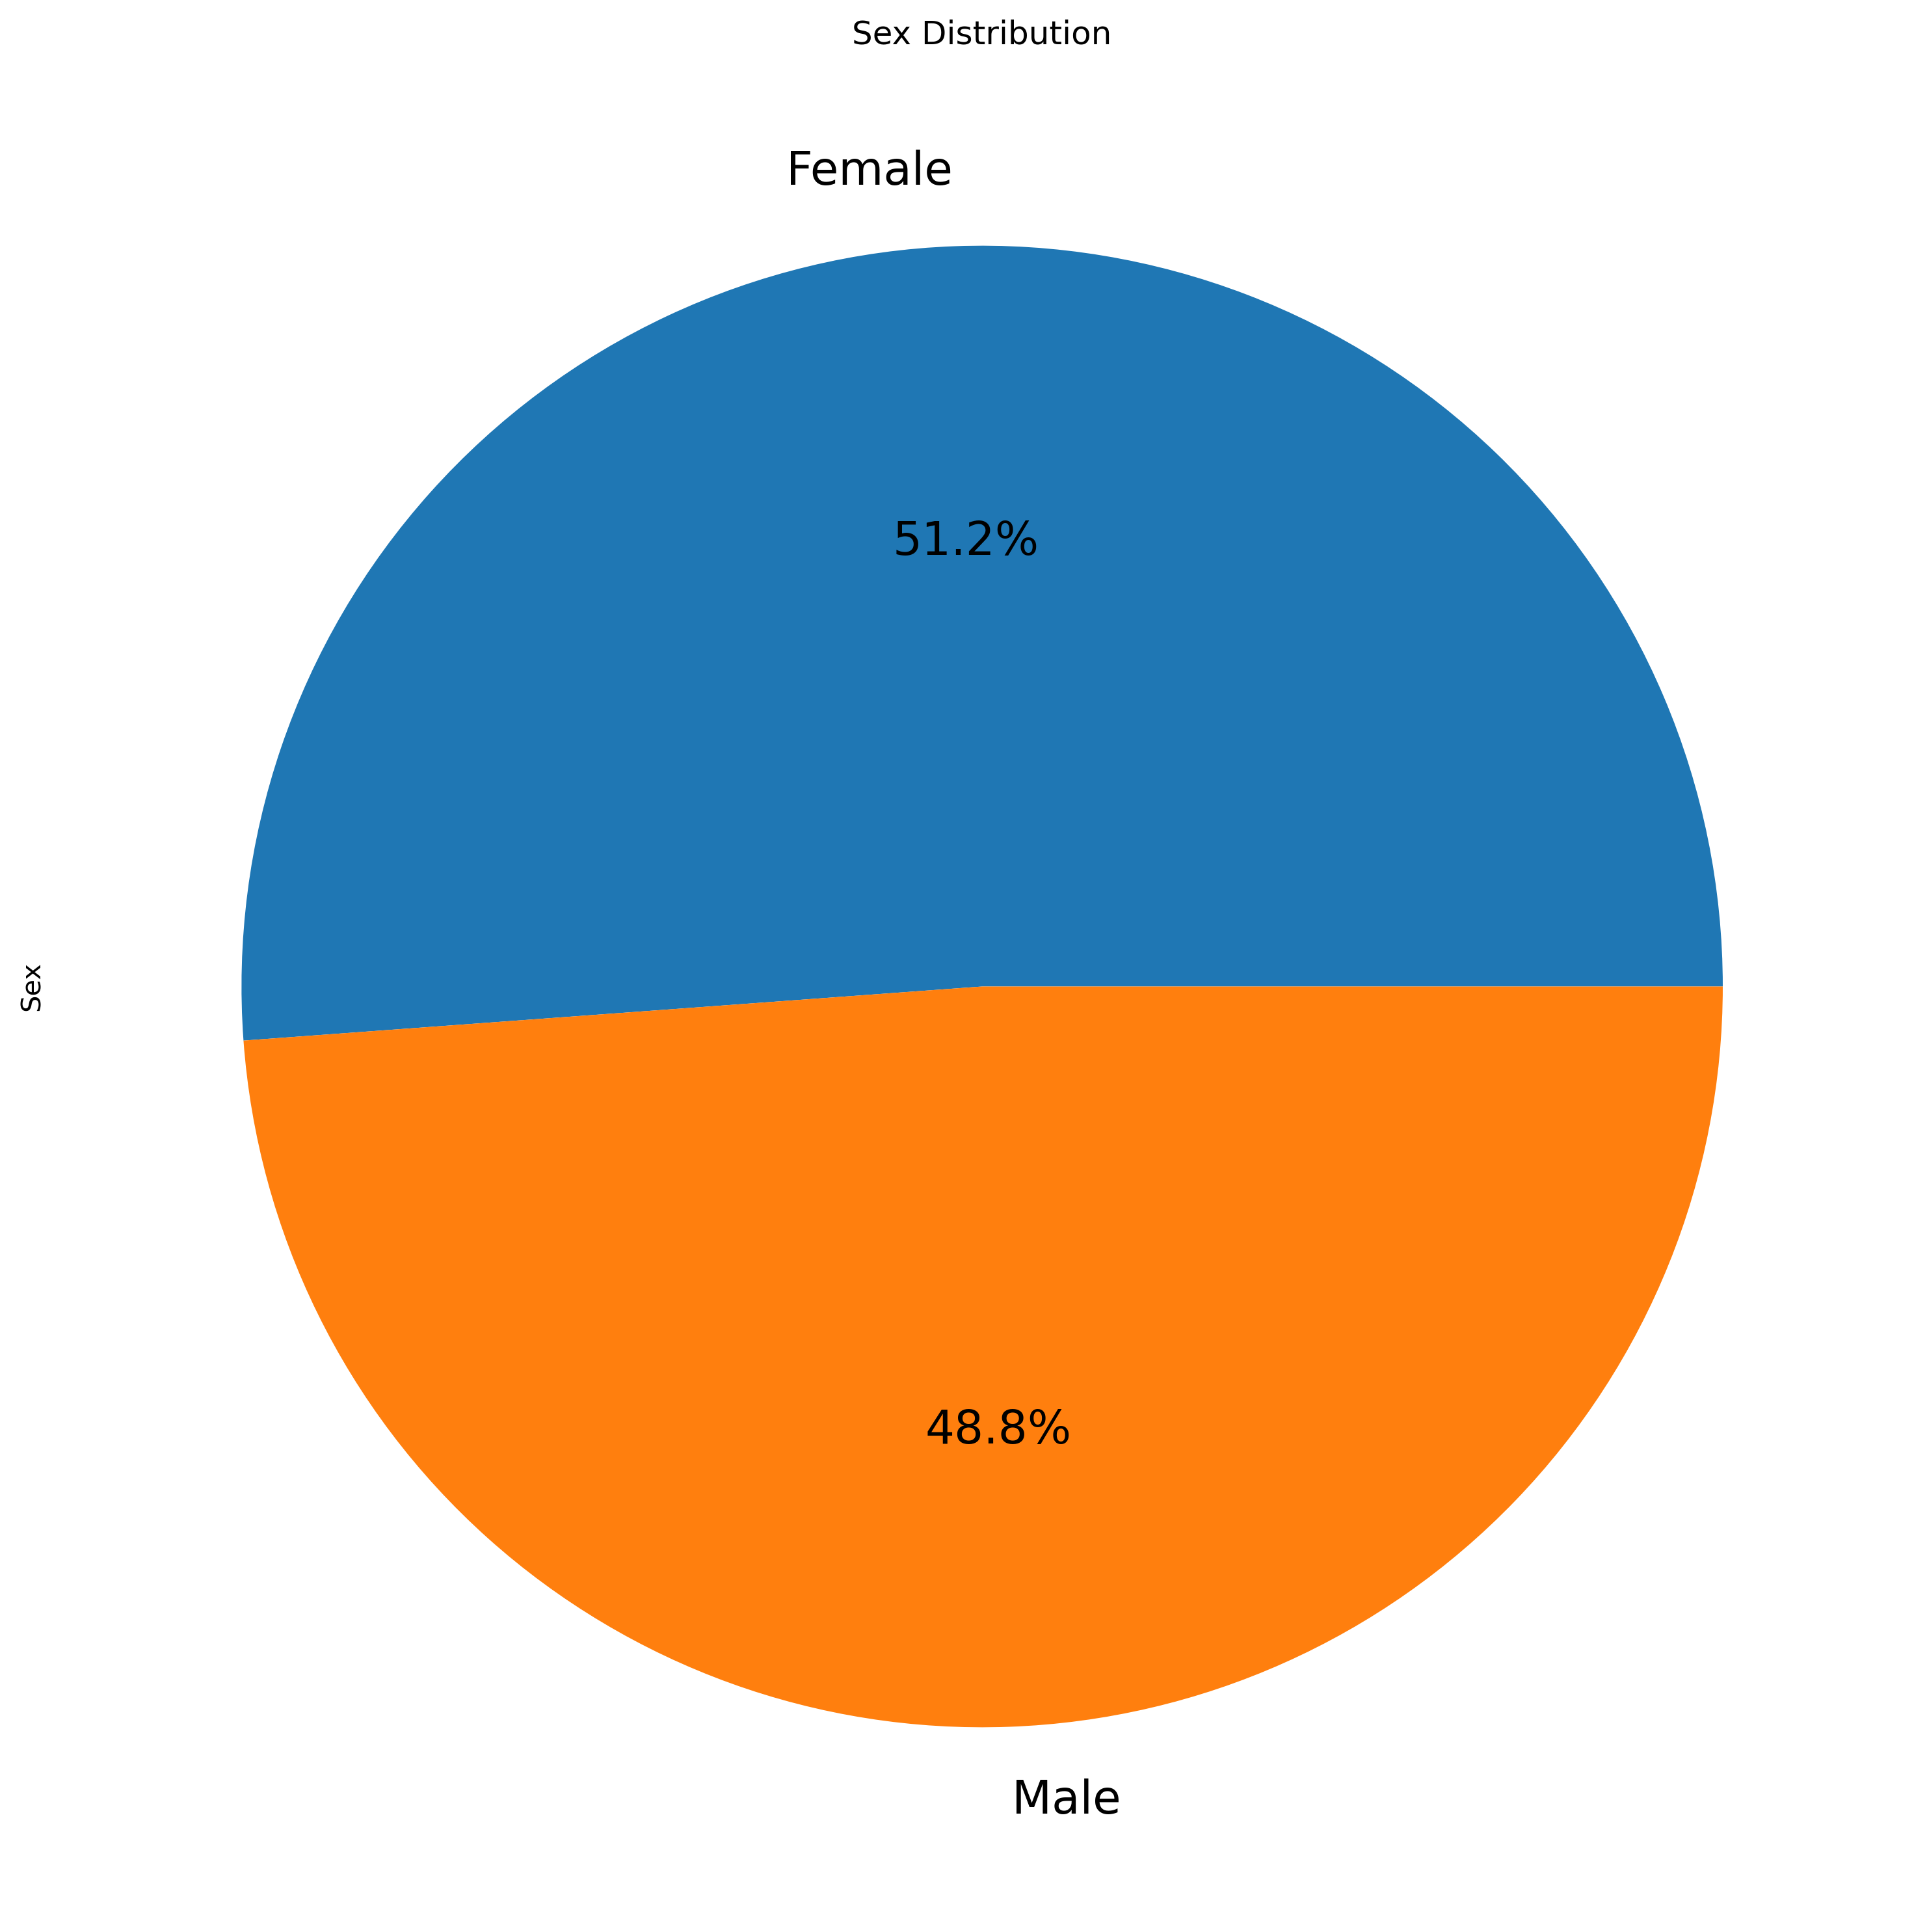

In [113]:
df['Sex'].value_counts().plot(kind='pie',
                              figsize=(15,10),
                              autopct='%1.1f%%',
                              fontsize=17,
                              title='Sex Distribution');
plt.gcf().set_dpi(300)
plt.tight_layout()
plt.savefig('imgs/sex_distribution.png', dpi=300)

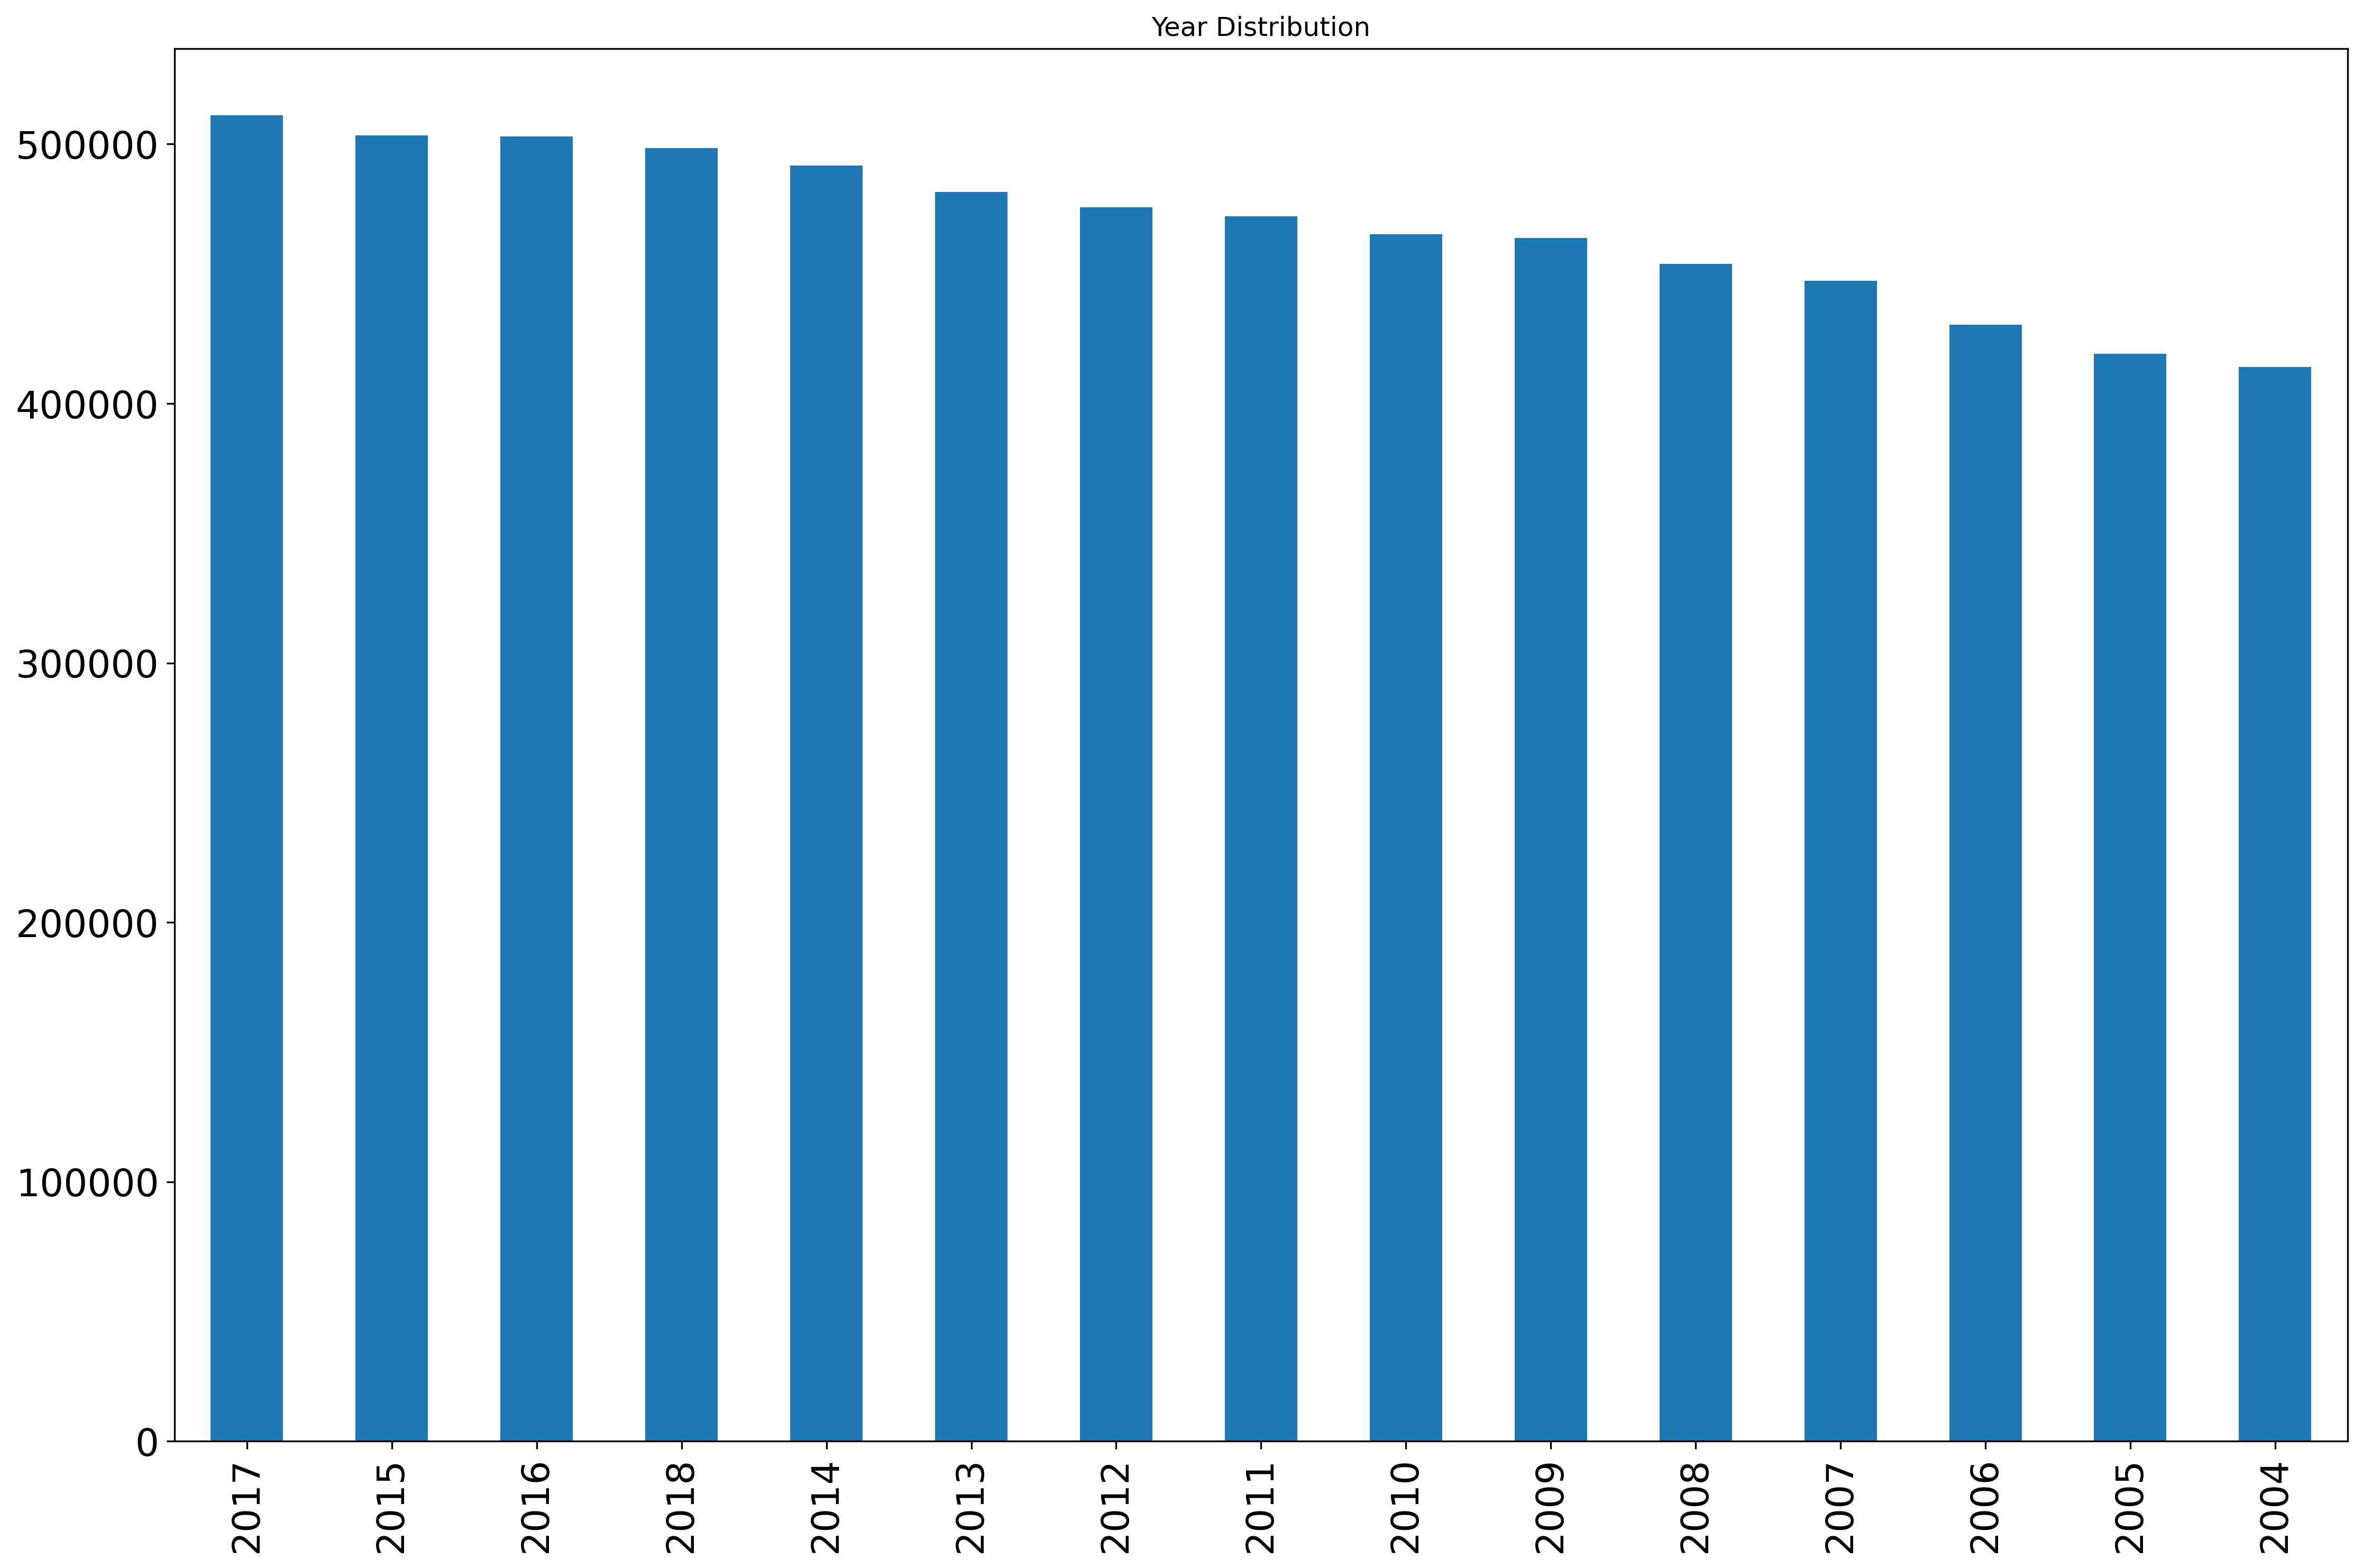

In [114]:
df['Year_of_diagnosis'].value_counts().plot(kind='bar',
                                            figsize=(15,10),
                                            fontsize=17,
                                            title='Year Distribution');
plt.tight_layout()
plt.gcf().set_dpi(300)


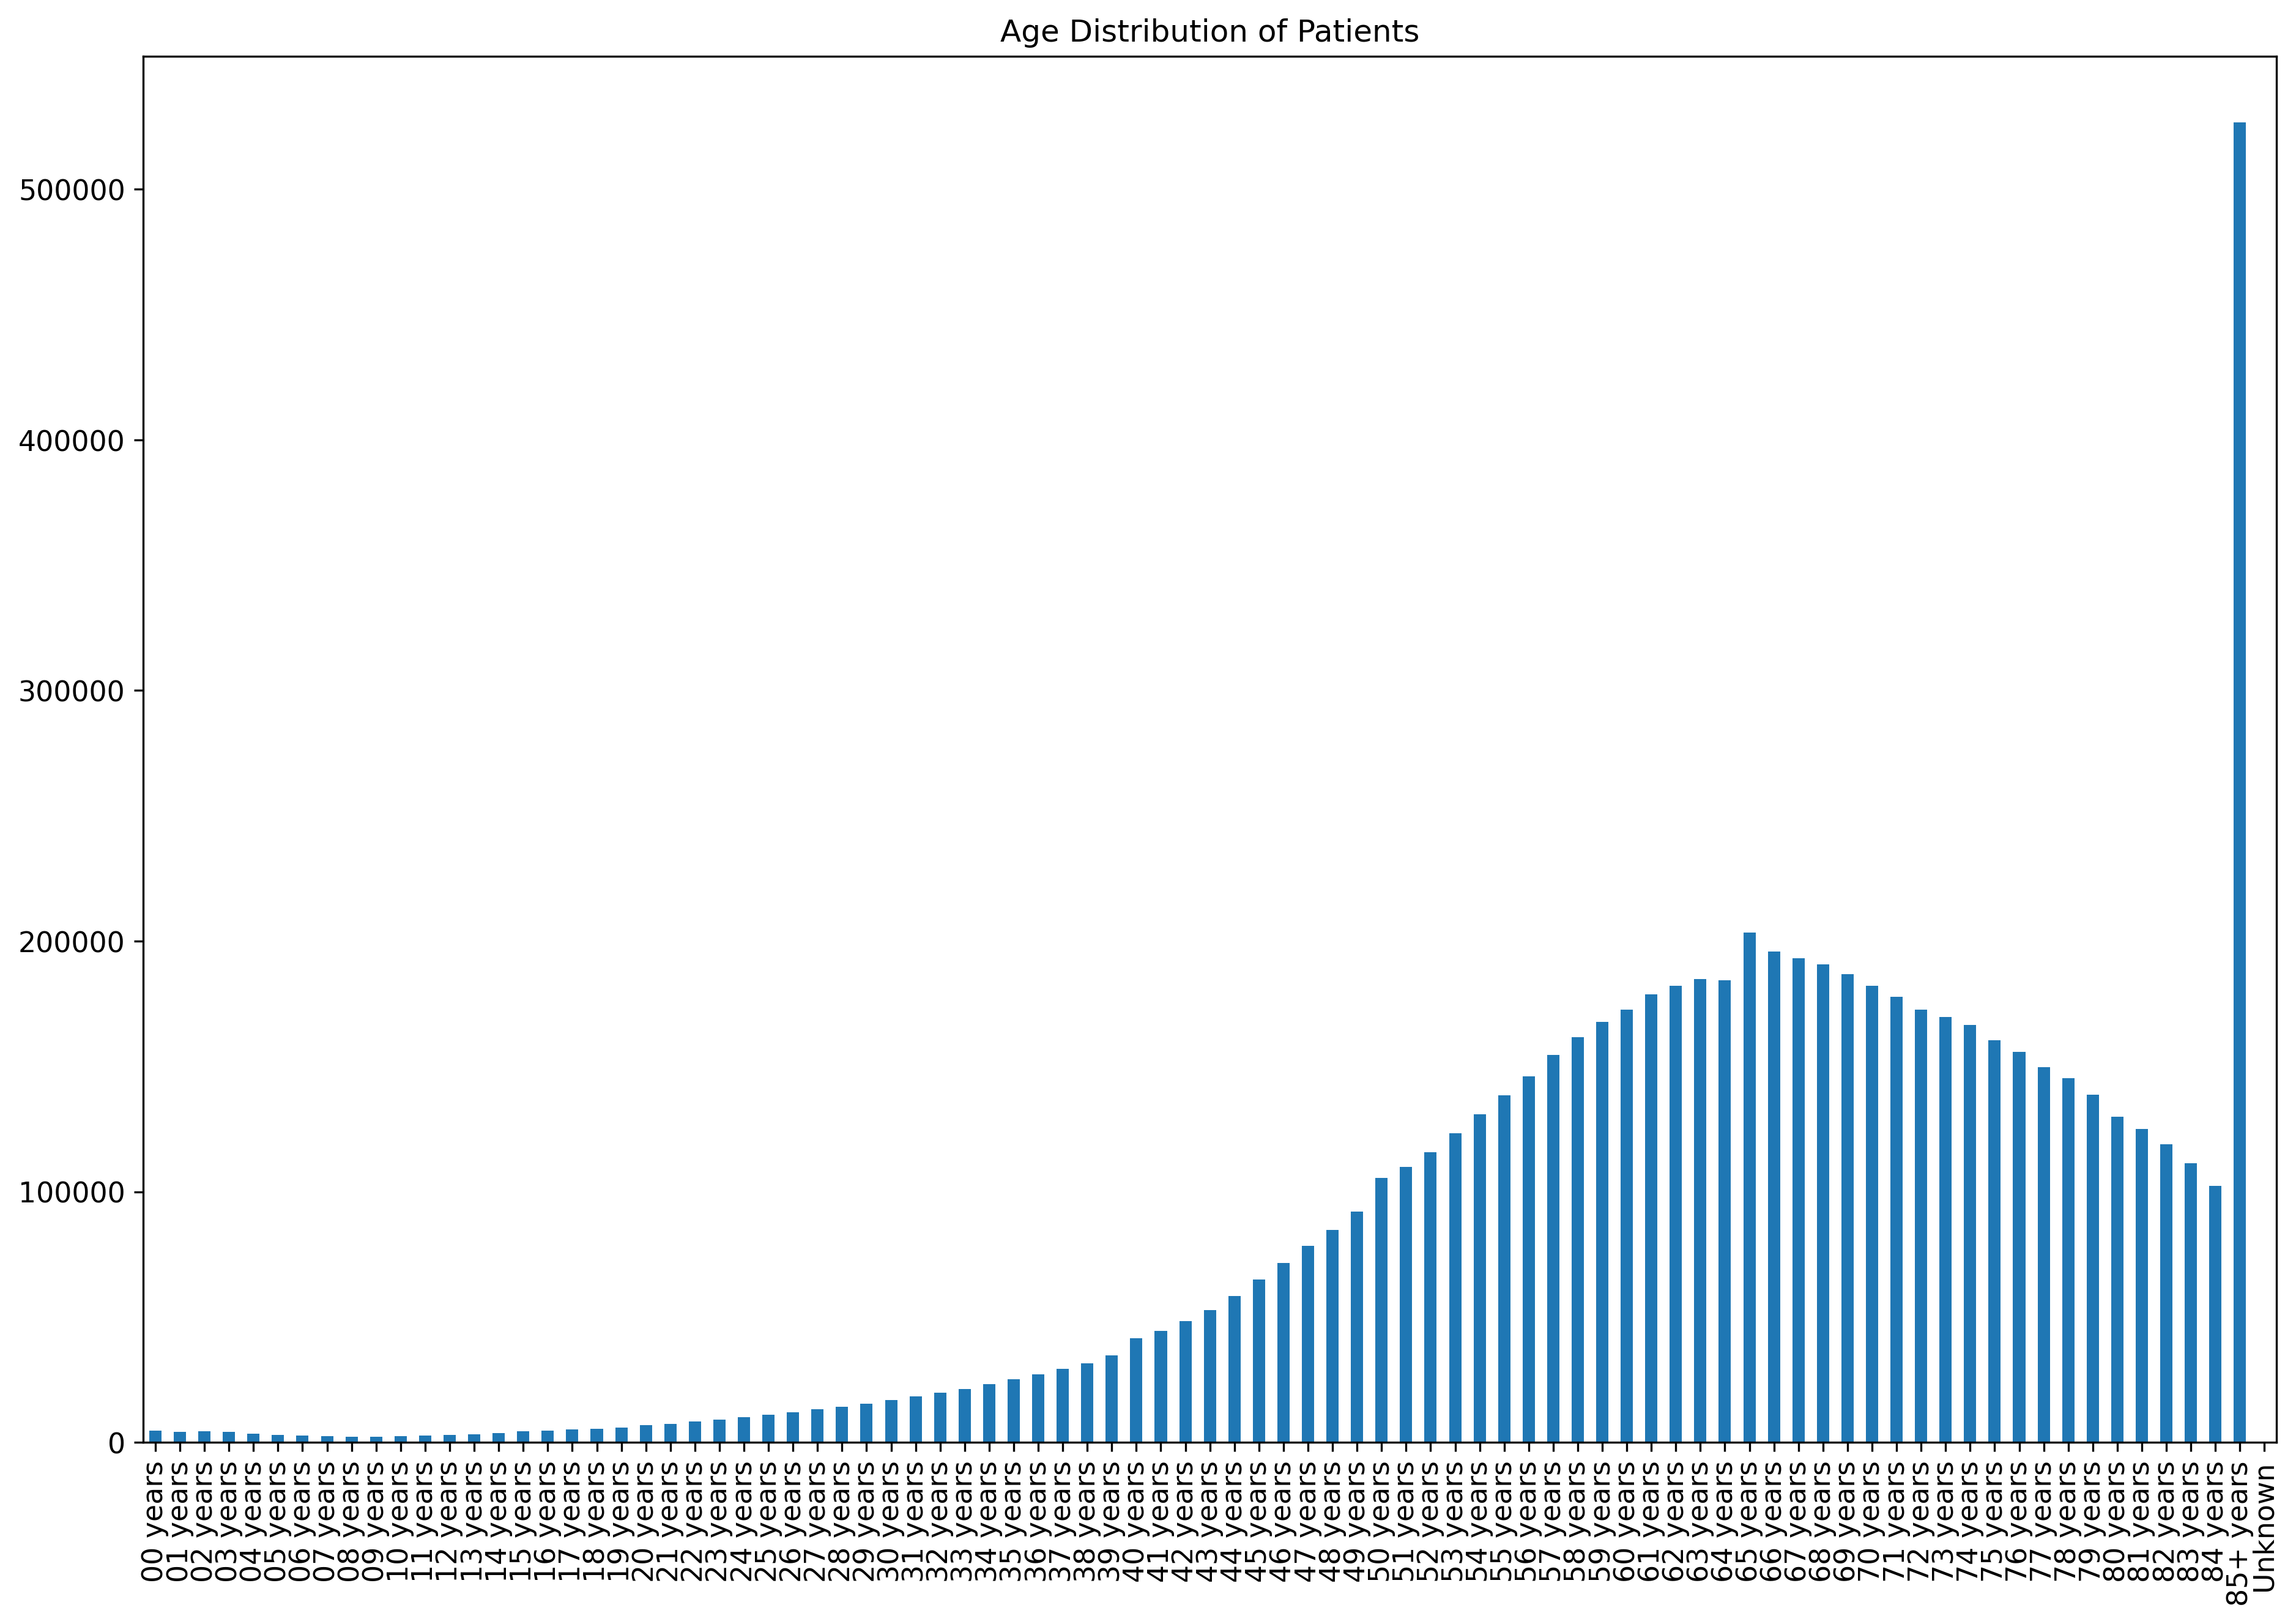

In [115]:
df['Age_recode_with_single_ages_and_85'].value_counts().sort_index().plot(kind='bar',figsize=(15,10), 
                                                             title='Age Distribution of Patients',
                                                             fontsize=11,);
plt.gcf().set_dpi(300)
plt.savefig('imgs/age_distribution.png', dpi=300)

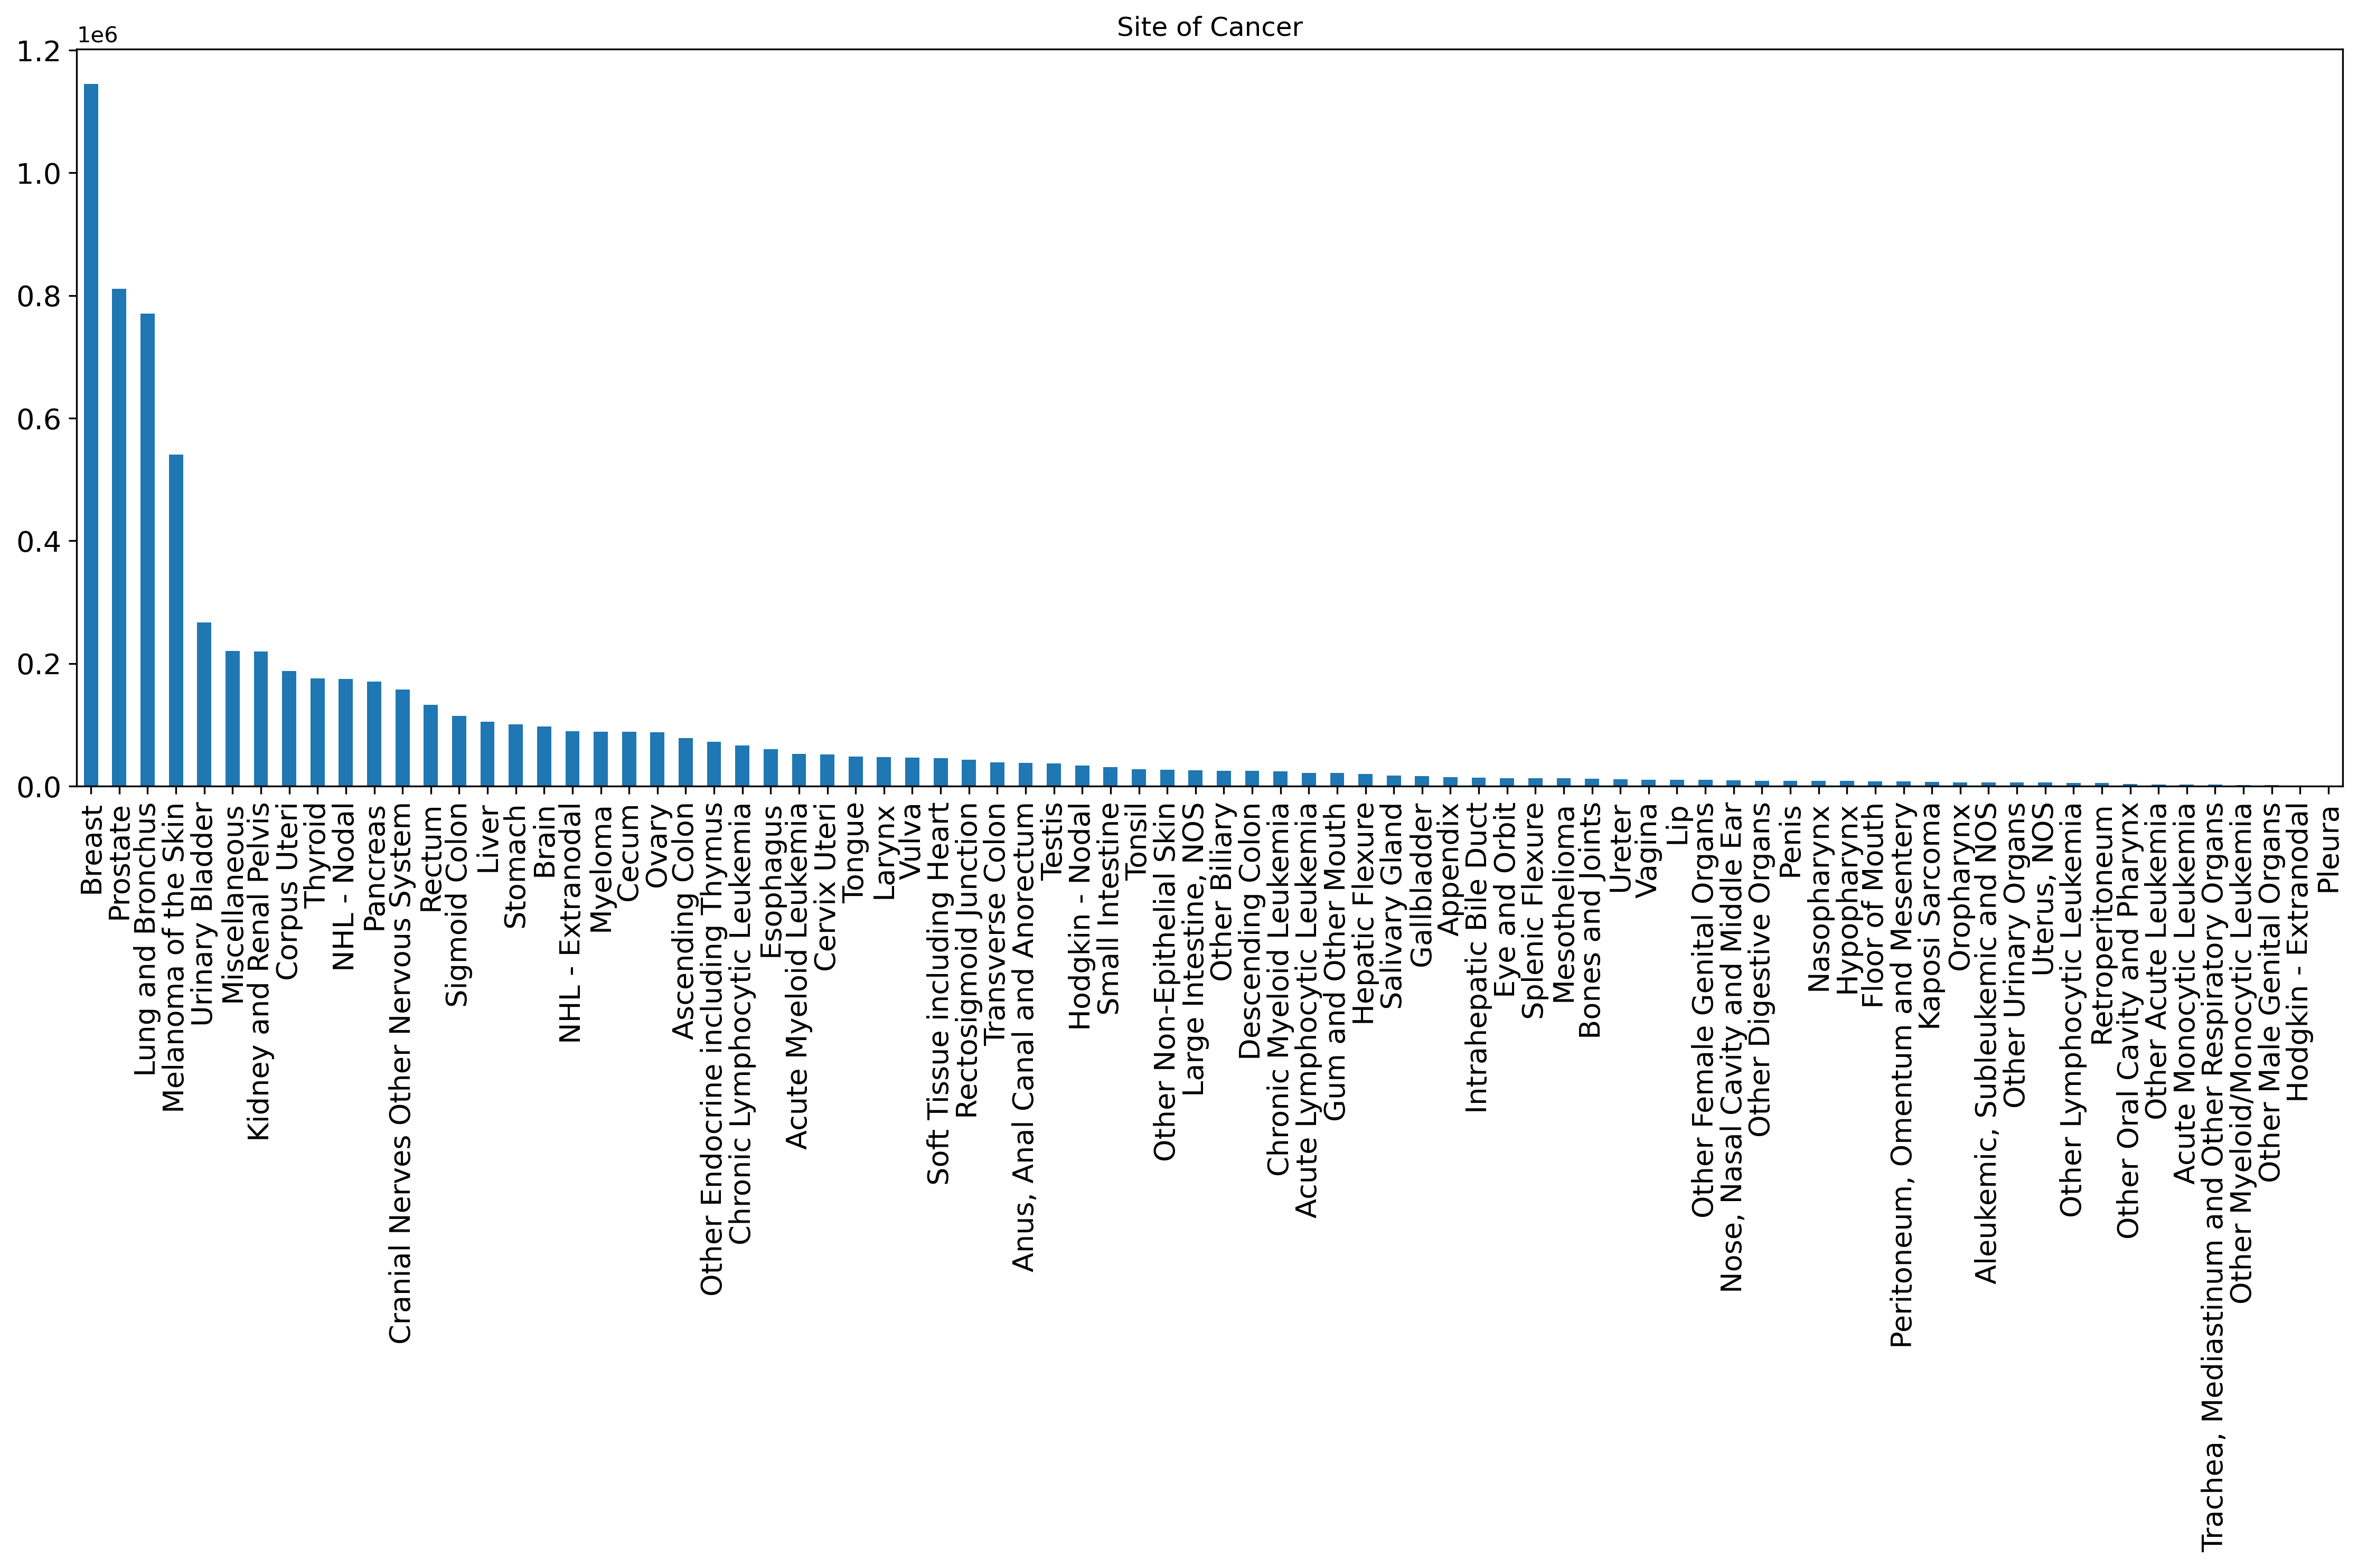

In [116]:
df['Site_recode_ICD_O_3_WHO_2008'].value_counts().plot(kind='bar',figsize=(15,10), 
                                                      title='Site of Cancer',
                                                      fontsize=13,);
plt.gcf().set_dpi(300)
plt.tight_layout()

plt.savefig('imgs/site_record.png', dpi=300)

In [117]:
df['Survival_months']

2          0131
3          0000
4          0026
7          0142
8          0094
           ... 
8666657    0000
8666658    0000
8666659    0000
8666660    0000
8666661    0034
Name: Survival_months, Length: 7030345, dtype: object

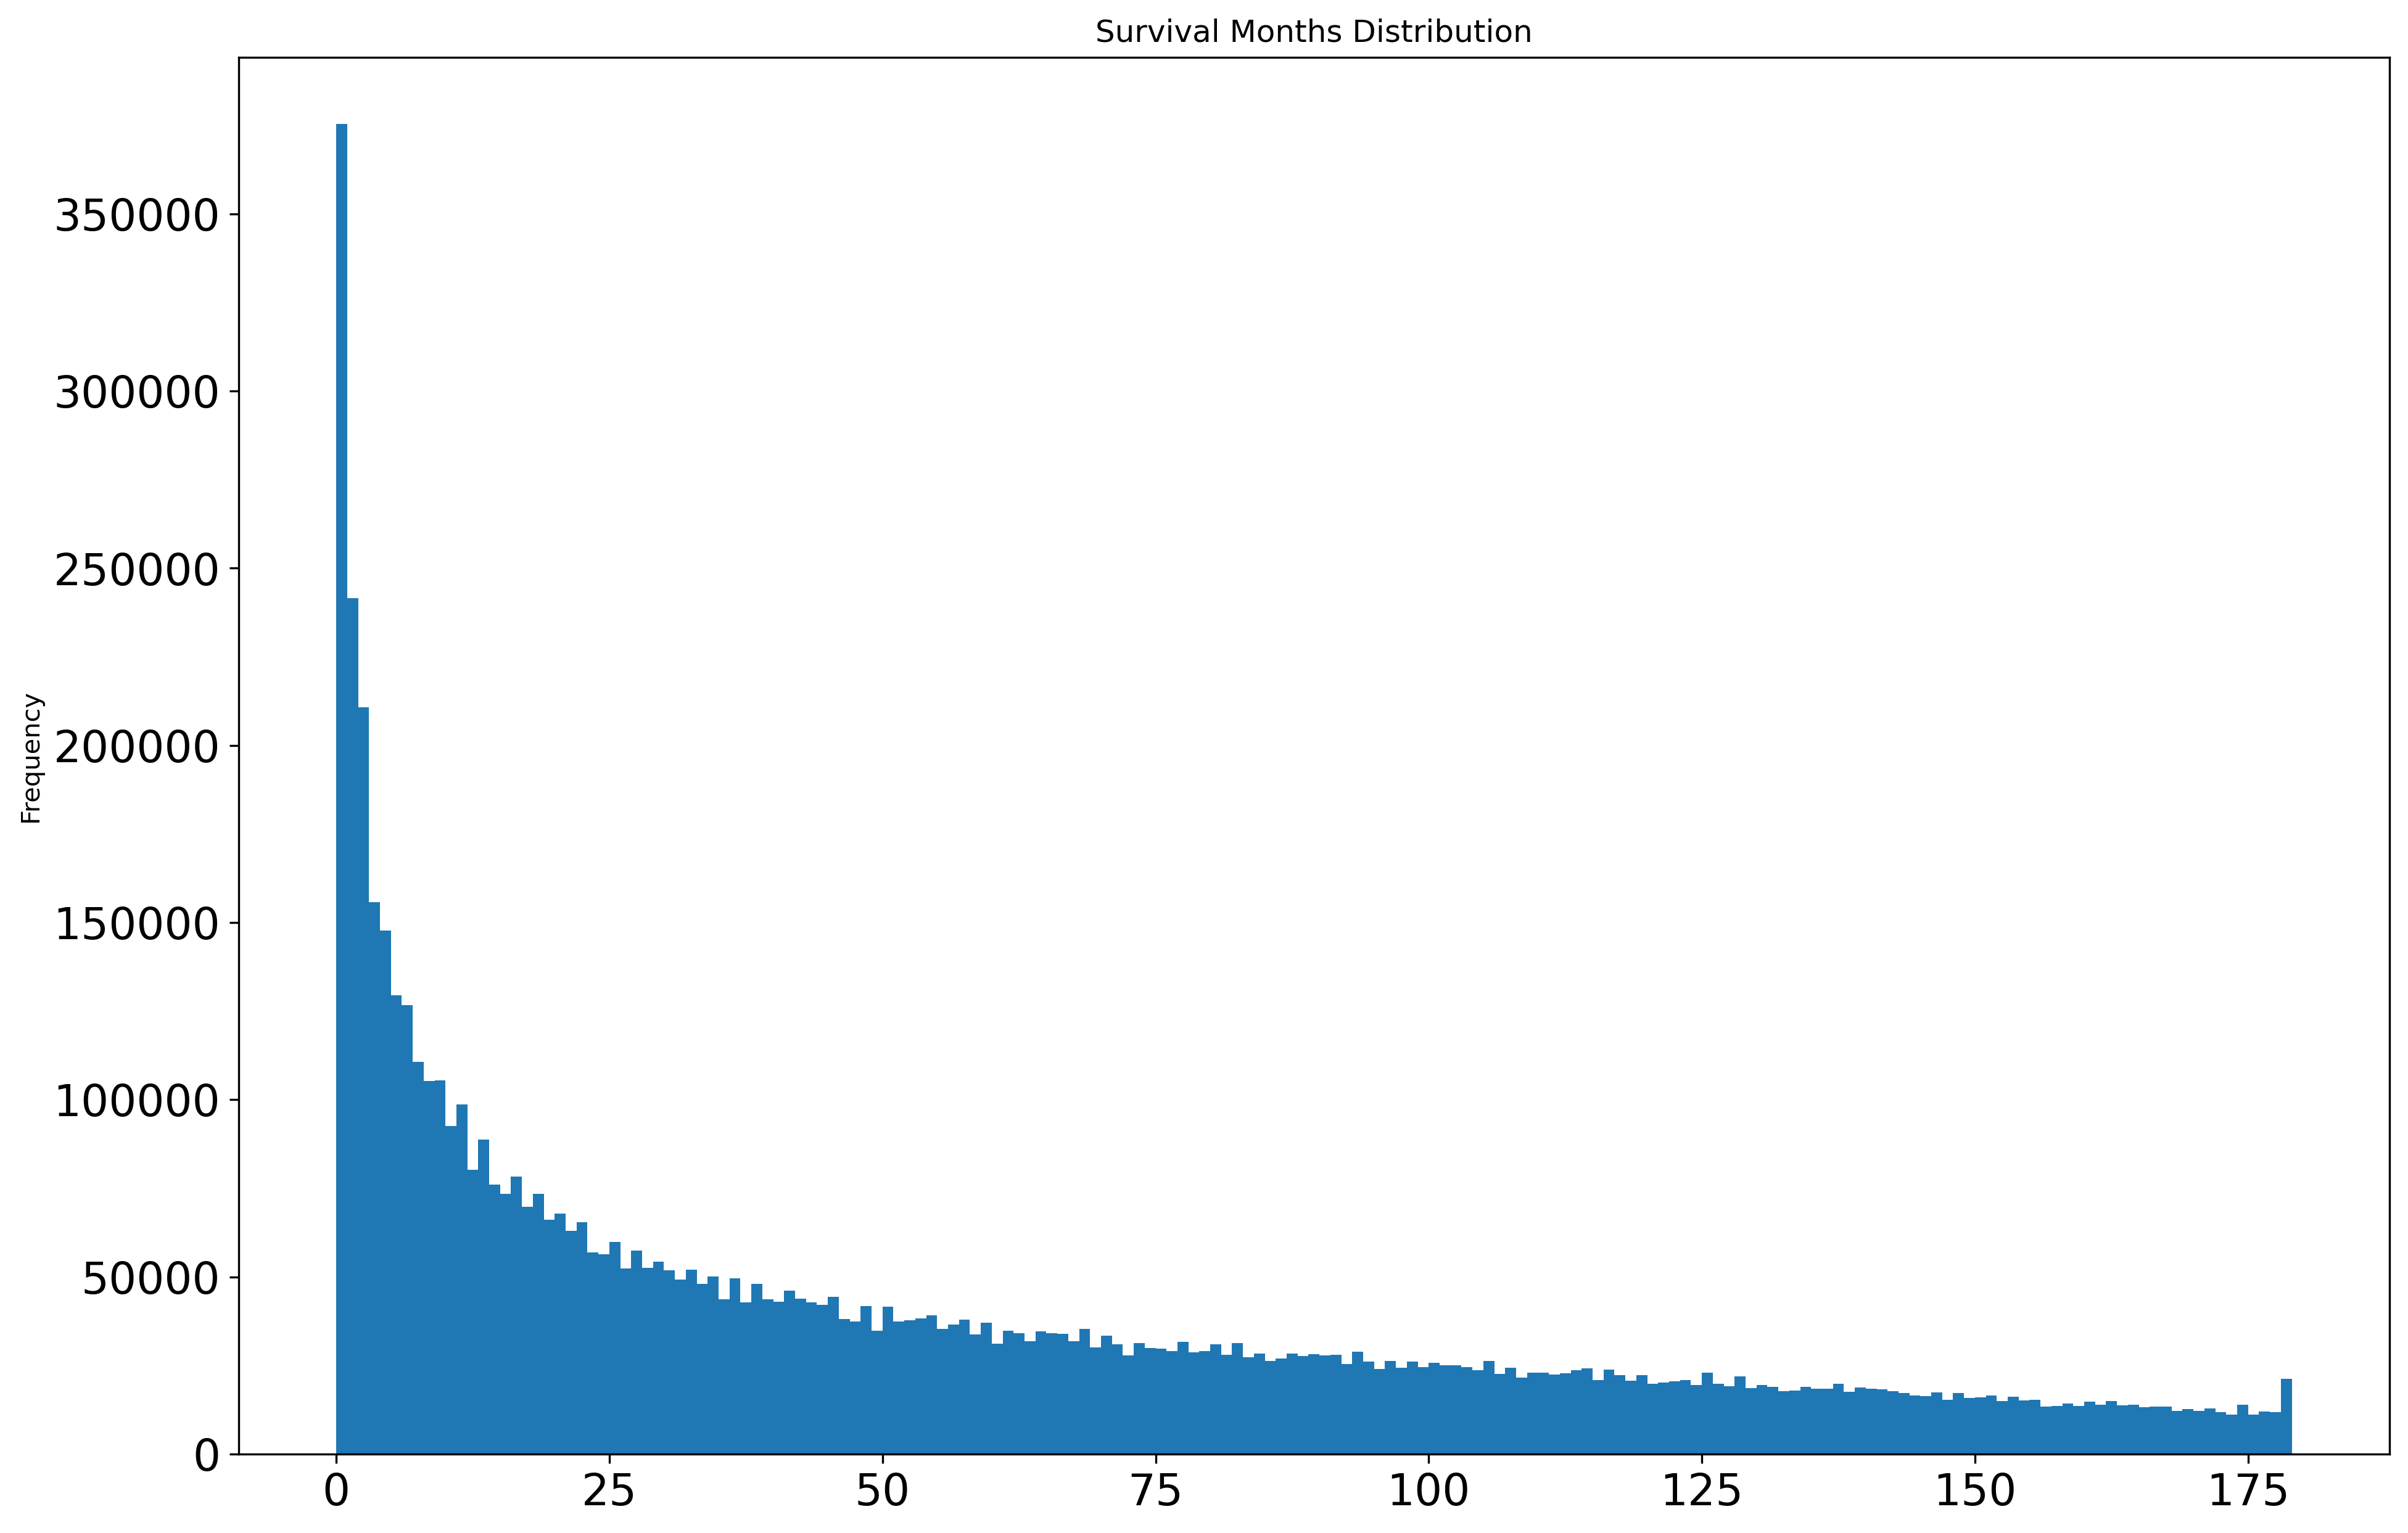

In [120]:
df['Survival_months'] = pd.to_numeric(df['Survival_months'],errors='coerce') #change survival months to a numeric type
df['Survival_months'].plot(kind='hist',figsize=(15,10), bins=int(df['Survival_months'].max()),
                                    title='Survival Months Distribution',
                                    fontsize=17,);
plt.gcf().set_dpi(300)
plt.savefig('imgs/Survival_Months_Distribution.png', dpi=300)

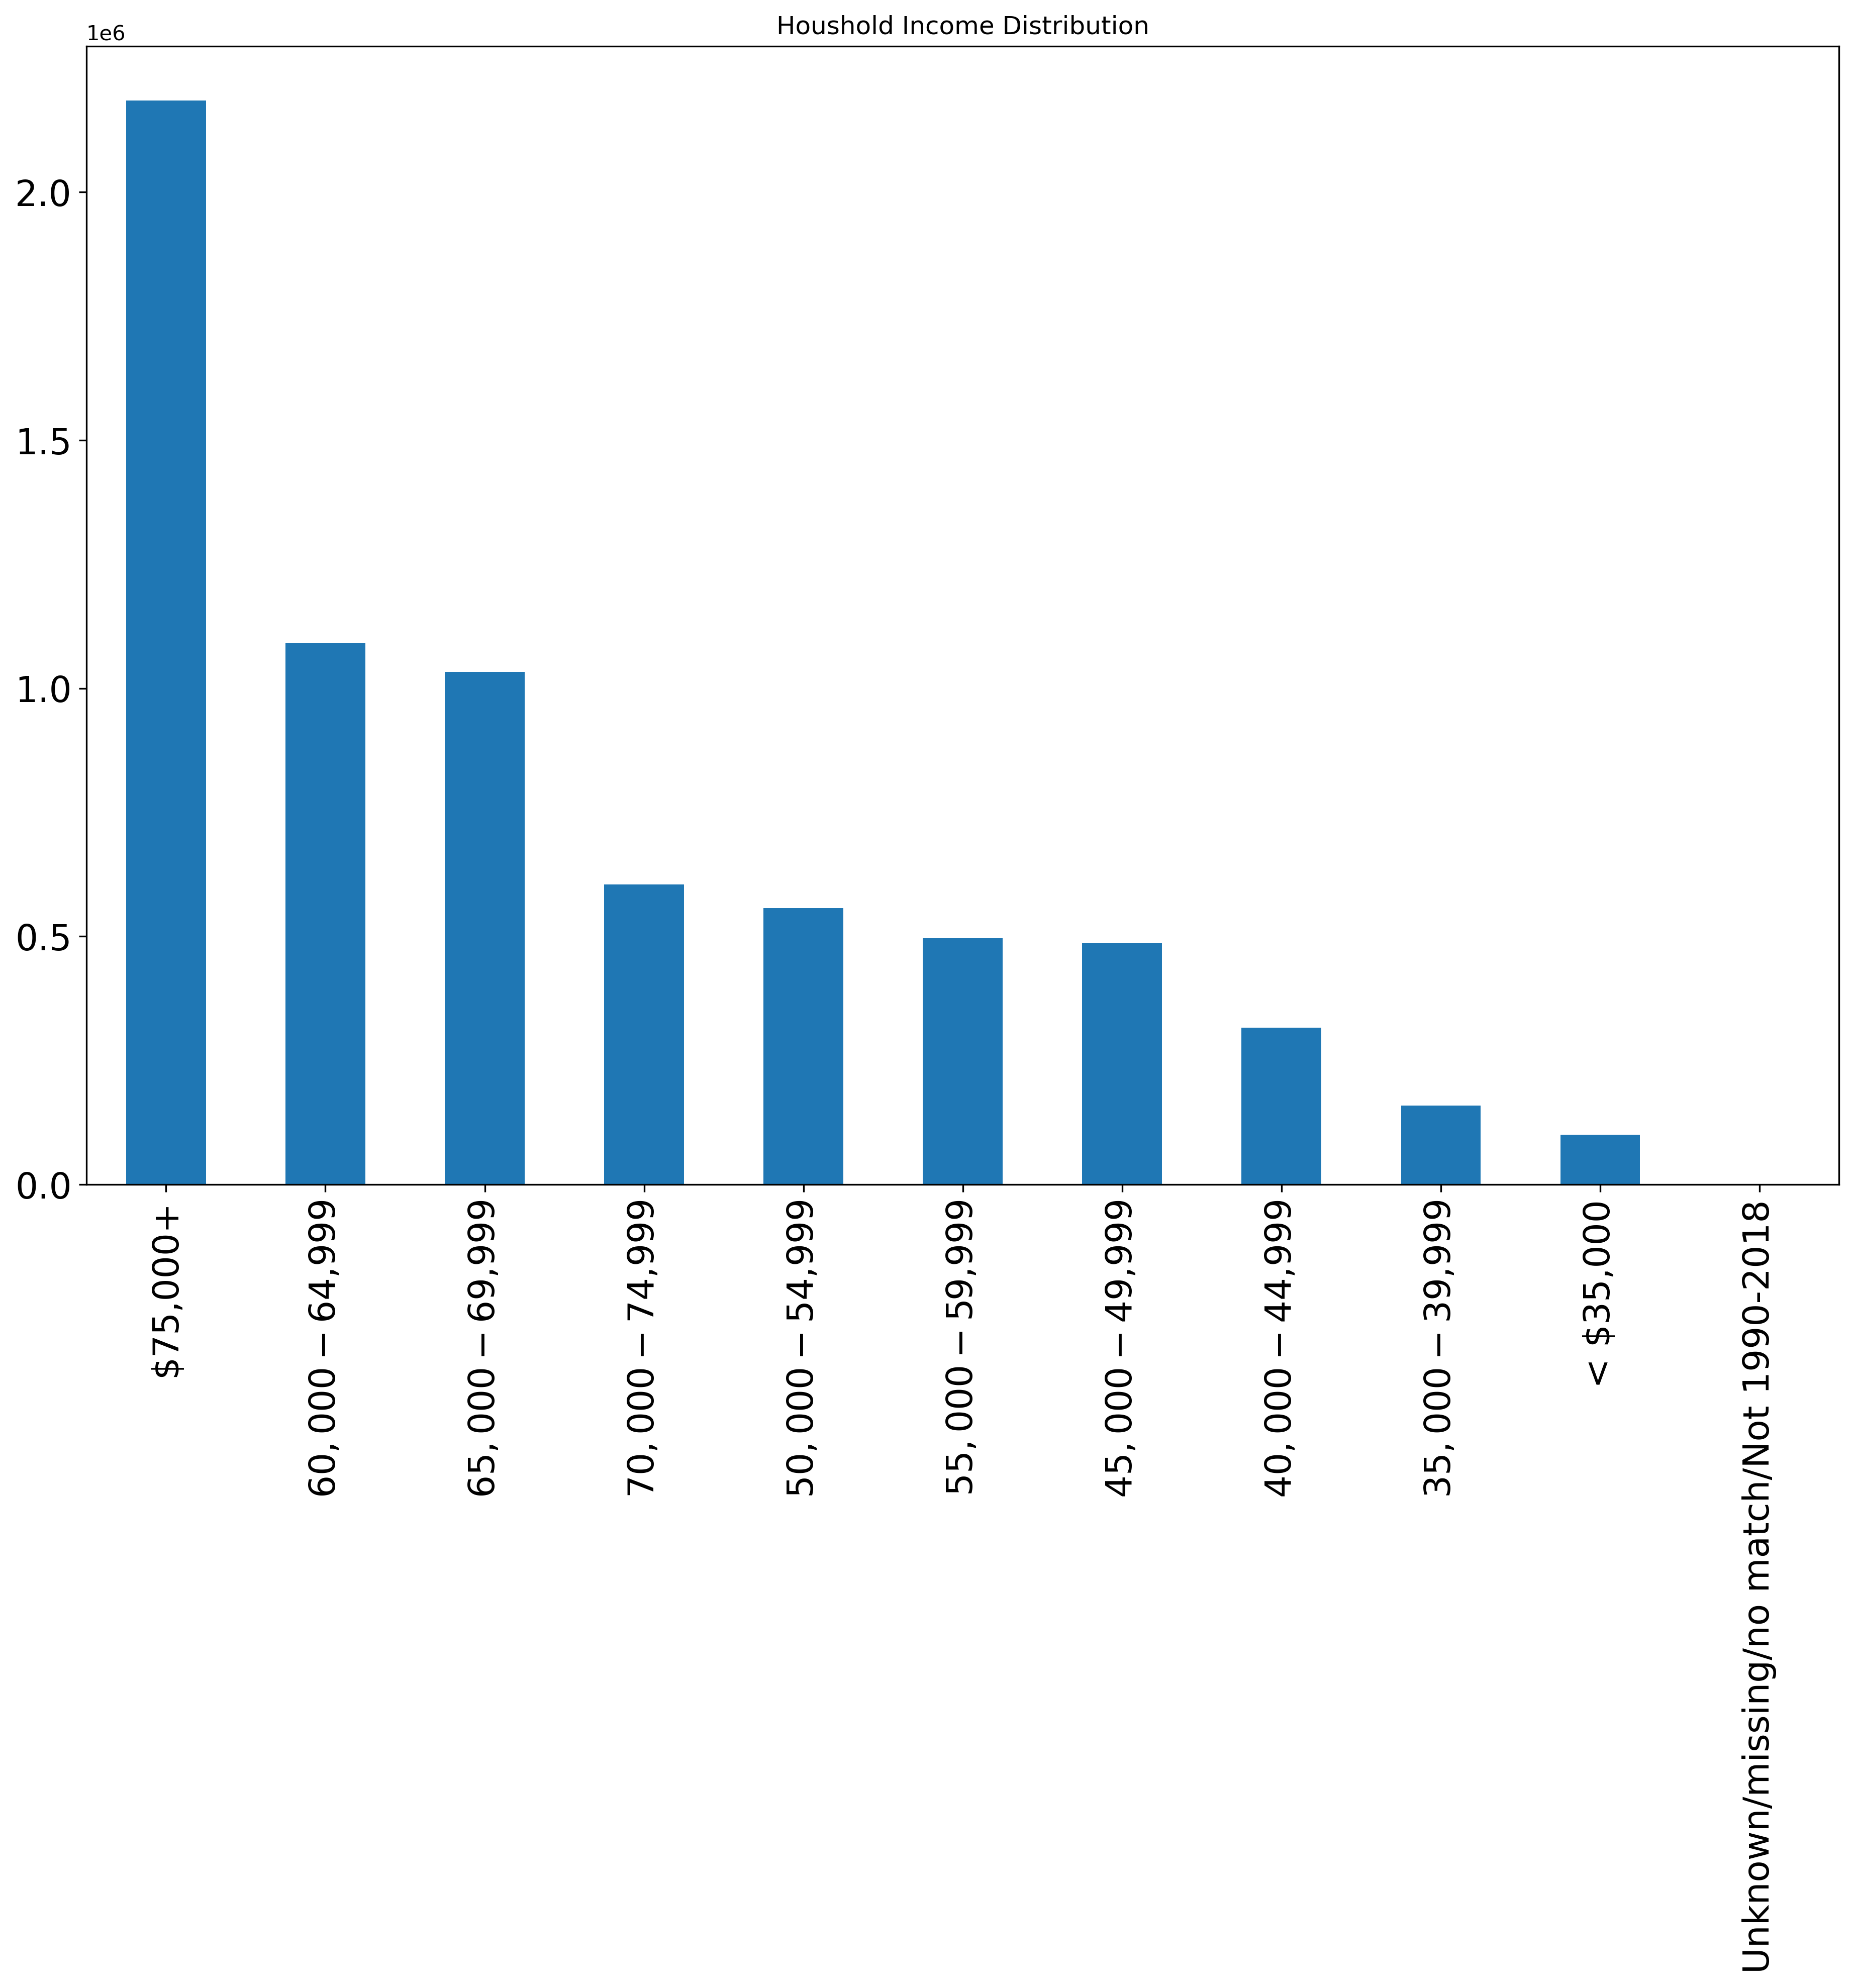

In [14]:
df['Median_household_income_inflation_adj_to_2019'].value_counts().plot(kind='bar',figsize=(15,10), 
                                                                        title='Houshold Income Distribution',
                                                                        fontsize=17,);
plt.gcf().set_dpi(300)

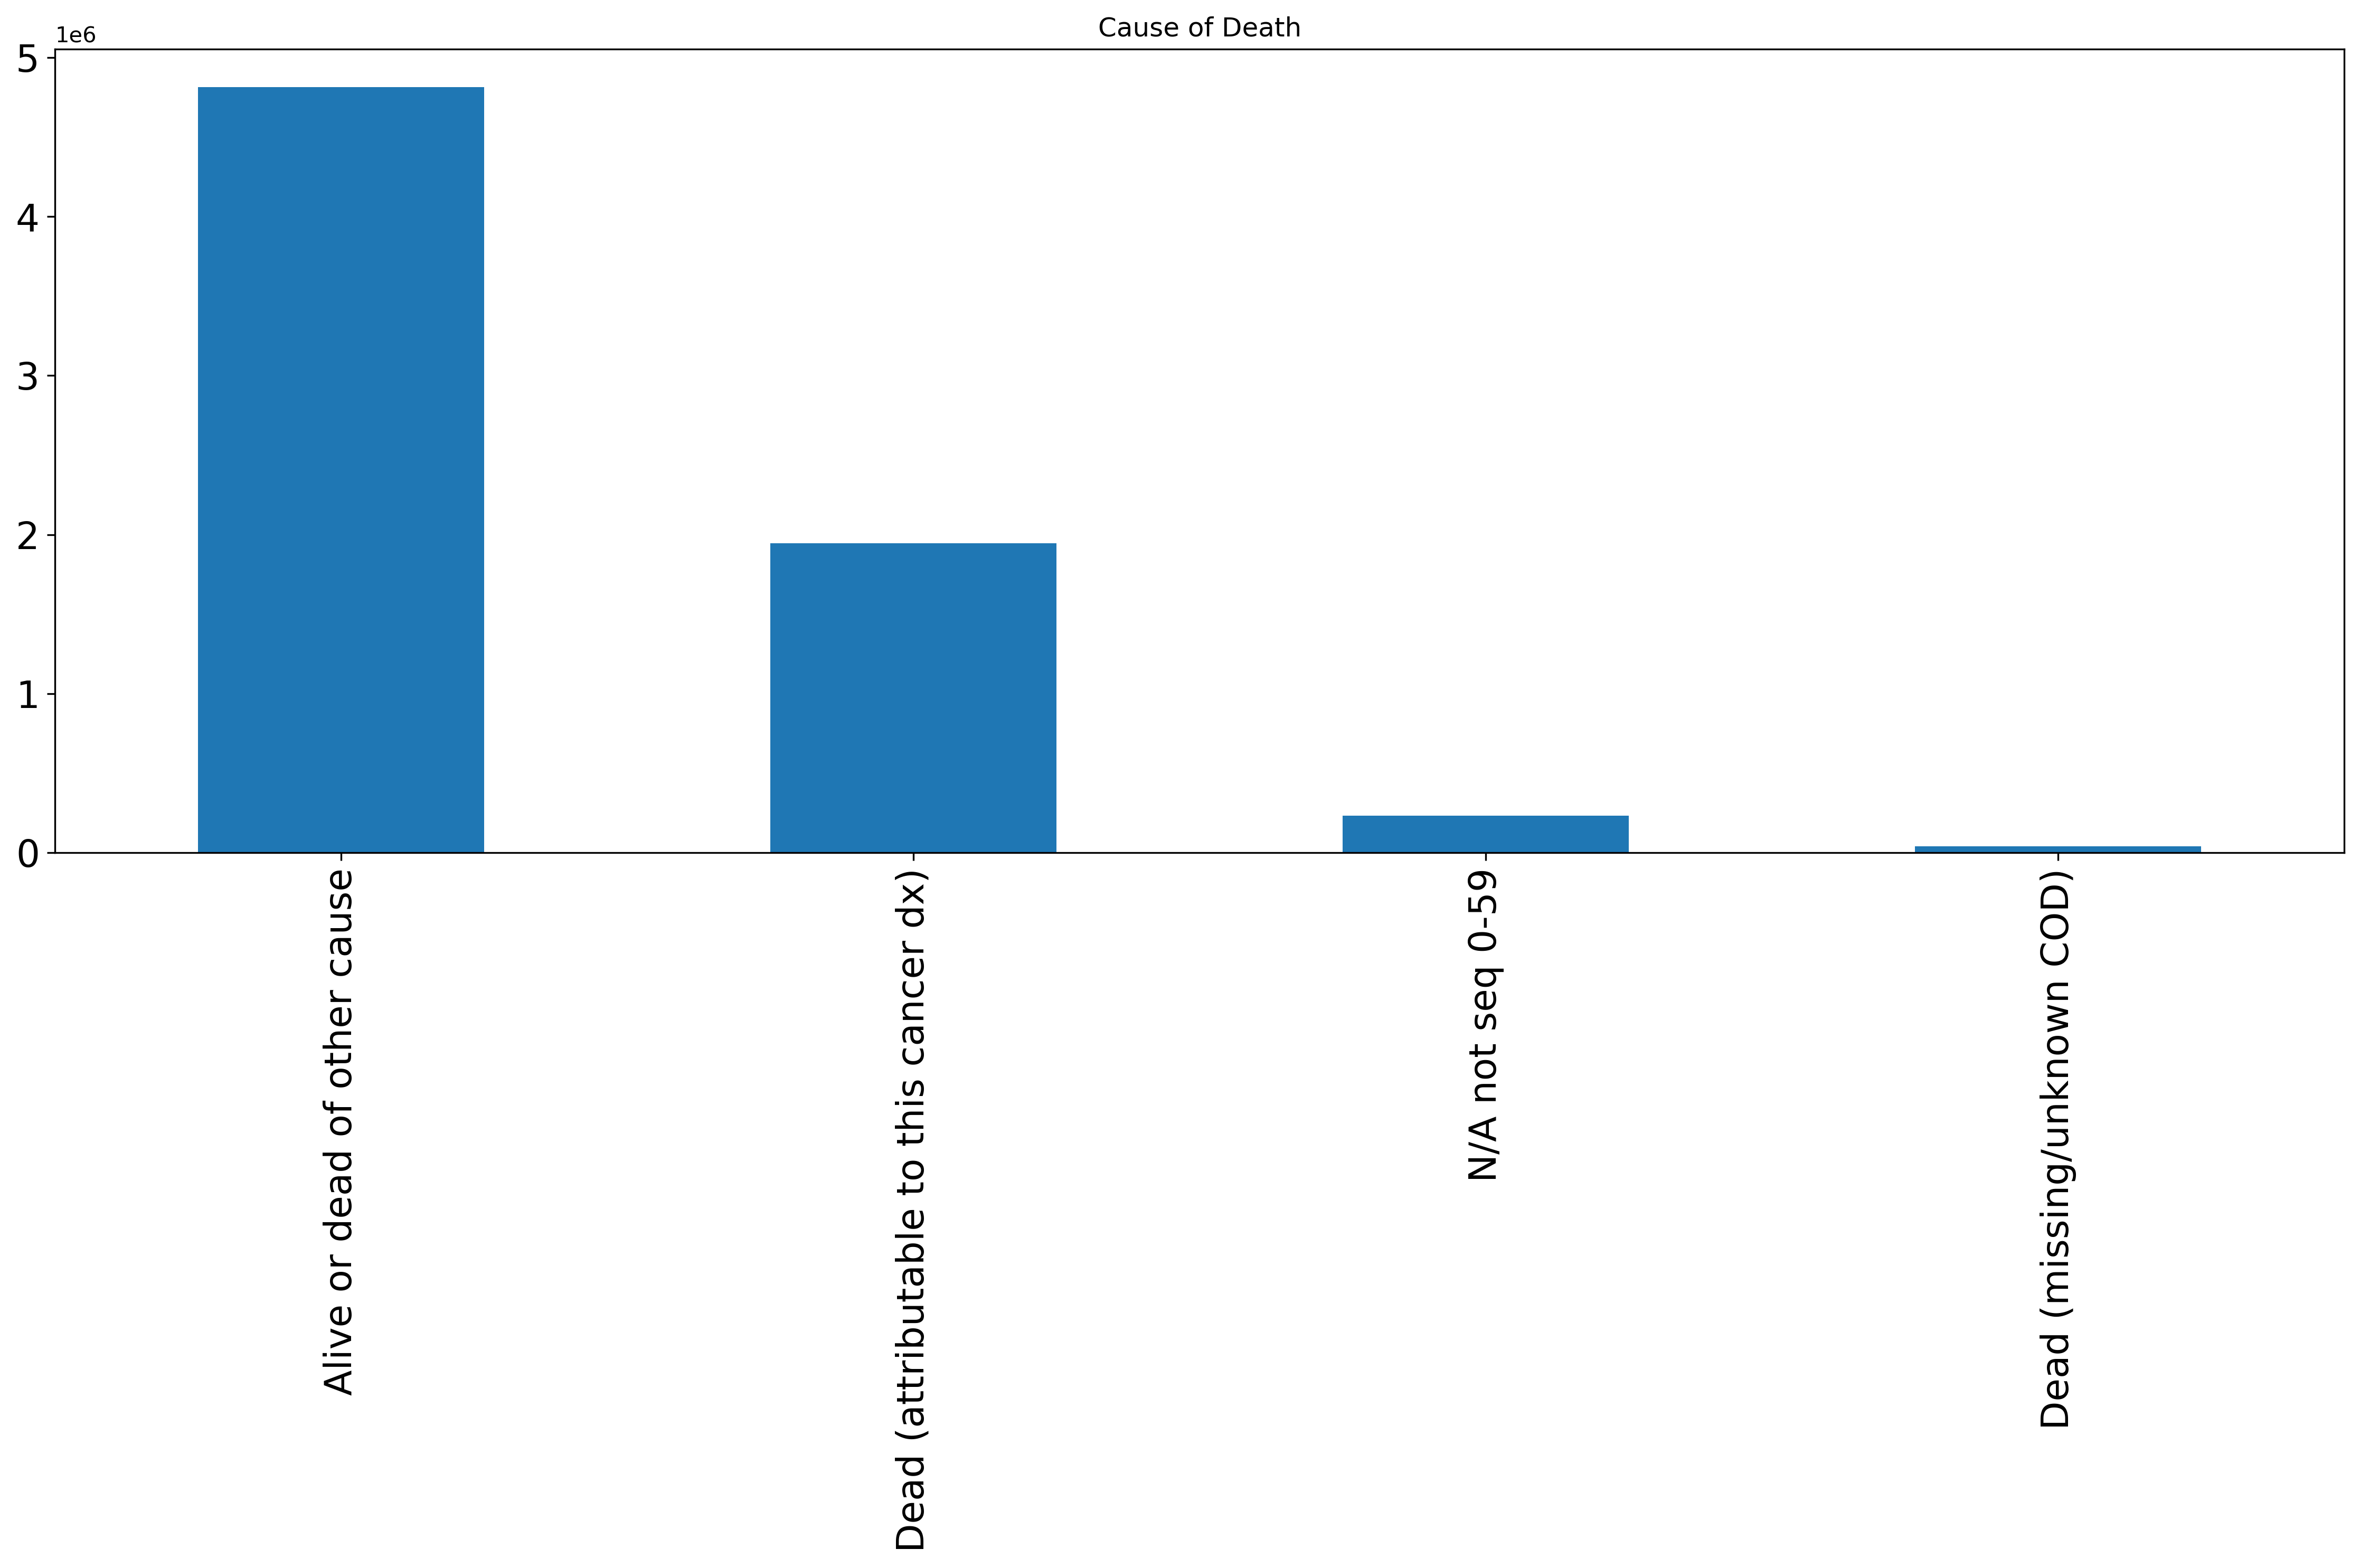

In [121]:
df['SEER_cause_specific_death_classification'].value_counts().plot(kind='bar',figsize=(15,10), 
                                                                        title='Cause of Death',
                                                                        fontsize=17,);
plt.gcf().set_dpi(300)
plt.tight_layout()

plt.savefig('imgs/cause_of_death.png', dpi=300)

## Machine Learning

Now it comes to the learning part. We are going to find answers to two questions: 
1. Is it possible to predict whether or not the patient eventually would pass away due to complications associated with his/her cancer?
2. For patients who eventually pass away due to cancer, can we predict the time period during which the patient is expected to survive?

The first problem is a binary classification problem while the second one is a regression problem to predict the number of months the patient is expected to survive. 













## Predict Chance of Survival

In this section, we try to answer the first question that is to predict whether or not the cancer would be the main cause of death in each patient. Some columns are of object type by nature; examples include `Sex, Race, Laterality`. But, some columns can be interpreted as a mixed type. For example, `Age recode with single ages and 85+` column contains the information regarding the age of patient. However, if patients are older than 85, a single category is assigned to them. In other words, a patients with 85 years is assigned to the same category as the patient of age 92. There are three [ways to encode categorical variables](https://machinelearningmastery.com/how-to-prepare-categorical-data-for-deep-learning-in-python/). The most common approach is to use One Hot Encoding also known as dummy encoding. However, as we will see this approach is not always the best option because first of all it is computationally complex (the generated matrices are HUGE). Also, when using one hot encoding the encoded features are all orthogonal to each other which is far from being accurate.

Let us first try one hot encoding to see its performance.  



<!-- For this reason, we tried two different approaches to solve the problem. 
1. Try to change columns to numeric type as much as possible. For example, change the Age column to numeric value and ignore the fact the patients older than 85 are assigned the same age. 
2. Do not change data types and work directly with categorical data.

The two approaches are explored and compared in the following. Let's first change the columns as much as possible.  -->

### One hot encoding

Most columns are of 'object' type. Then, some data types need to be modified. 

In [16]:
df.dtypes

Sex                                                      object
Year_of_diagnosis                                         int64
Race_recode_W_B_AI_API                                   object
Origin_recode_NHIA_Hispanic_Non_Hisp                     object
Site_recode_ICD_O_3_WHO_2008                             object
Behavior_code_ICD_O_3                                    object
Grade_thru_2017                                          object
Laterality                                               object
Diagnostic_Confirmation                                  object
SEER_Combined_Summary_Stage_2000_2004_2017               object
Derived_AJCC_Stage_Group_6th_ed_2004_2015                object
Derived_AJCC_T_6th_ed_2004_2015                          object
Derived_AJCC_N_6th_ed_2004_2015                          object
Derived_AJCC_M_6th_ed_2004_2015                          object
Reason_no_cancer_directed_surgery                        object
RX_Summ__Scope_Reg_LN_Sur_2003          

#### Change data types to numeric

First of all, it seems that nan is partly represented with the string 'Blank(s)' in the entire dataset. Let's replace 'Blanks(s)' with nan. 

In [17]:
df.replace('Blank(s)',np.nan,inplace=True)
df.replace('Recode not available',np.nan,inplace=True)
df.replace('UNK Stage',np.nan,inplace=True)
df.isnull().mean()
# for col in df.columns:
#     if df[col].isna().sum() > 0:
#         print(f'There are {df[col].isna().sum()} NaNs in column {col} corresponding to {df[col].isna().mean() * 100:.2f} percent of cases')

Sex                                                     0.000000
Year_of_diagnosis                                       0.000000
Race_recode_W_B_AI_API                                  0.000000
Origin_recode_NHIA_Hispanic_Non_Hisp                    0.000000
Site_recode_ICD_O_3_WHO_2008                            0.000000
Behavior_code_ICD_O_3                                   0.000000
Grade_thru_2017                                         0.070900
Laterality                                              0.000000
Diagnostic_Confirmation                                 0.000000
SEER_Combined_Summary_Stage_2000_2004_2017              0.070900
Derived_AJCC_Stage_Group_6th_ed_2004_2015               0.379551
Derived_AJCC_T_6th_ed_2004_2015                         0.355741
Derived_AJCC_N_6th_ed_2004_2015                         0.355808
Derived_AJCC_M_6th_ed_2004_2015                         0.355741
Reason_no_cancer_directed_surgery                       0.000000
RX_Summ__Scope_Reg_LN_Sur

In [18]:
df['Survival_months'] = pd.to_numeric(df['Survival_months'],errors='coerce') #change survival months to a numeric type

#####  Regional nodes examined (1988+)

This column follows the following convention:

![title](imgs/regional_nodes_examined.png)
The code 99 is almost the same as nan. As of the codes 95-98 we remove them all as they are actually associated with category and do not represent numbers. 

In [19]:
for i in [95,96,97,98]:
    df = df[df['Regional_nodes_examined_1988'] != i]
df['Regional_nodes_examined_1988'].replace(99,np.nan, inplace=True)
(df['Regional_nodes_examined_1988'] >= 95).sum() # just to make sure

0

##### Regional nodes positive (1988+)

This column follows the following convention:
![title](imgs/Regional_nodes_positive.png)
The code 98, 99 are almost the same as nan. 

In [20]:
df['Regional_nodes_positive_1988'].replace(98,np.nan, inplace=True)
df['Regional_nodes_positive_1988'].replace(99,np.nan, inplace=True)
df['Regional_nodes_positive_1988'].replace(97,np.nan, inplace=True)
df = df[df['Regional_nodes_positive_1988'] != 95]
(df['Regional_nodes_positive_1988'] > 90).sum()

0

##### CS tumor size (2004-2015)

This column follows the following convention:
![title](imgs/CS_tumor_size.png)
 888, 999 and 996-998 should be replaced with nan.
 For values between 991 to 995, we replace them with a random number. For example, for 991, we replace it with a number between 0-10 and for 992, we replace it with a random number between 10-20. The rational behind this replacement is that when we say Tumor size is less than 5cm but not less than 4cm, it should be within 4-5cm.

In [21]:
df['CS_tumor_size_2004_2015'].replace("'",'', inplace=True)
df['CS_tumor_size_2004_2015'] = pd.to_numeric(df['CS_tumor_size_2004_2015'])
for i in [888,999,996,997,998, 991, 992, 993, 994, 995]:
    df['CS_tumor_size_2004_2015'].replace(i,np.nan, inplace=True)
maping = {991:1, 992:2, 993:3, 994:4, 995:5}
for key, value in maping.items():
    df.loc[df['CS_tumor_size_2004_2015'] == key,'CS_tumor_size_2004_2015'] =\
    np.random.uniform(low=(value-1)*10, high=value*10, size=len(df.loc[df['CS_tumor_size_2004_2015'] == key]))
df['CS_tumor_size_2004_2015'].replace(990,0, inplace=True)    
(df['CS_tumor_size_2004_2015'] >= 990).sum()

0

##### CS extension (2004-2015)

In [22]:
df['CS_extension_2004_2015'].replace("'",'', inplace=True)
df['CS_extension_2004_2015'] = pd.to_numeric(df['CS_extension_2004_2015'])
df['CS_extension_2004_2015'].replace(999,np.nan, inplace=True)
(df['CS_extension_2004_2015'] >= 990).sum()

0

##### The number of In situ/ malignant tumors

In [23]:
df['Total_number_of_in_situ_malignant_tumors_for_patient'] = \
            pd.to_numeric(df['Total_number_of_in_situ_malignant_tumors_for_patient'],errors='coerce')

df['Total_number_of_benign_borderline_tumors_for_patient'] = \
            pd.to_numeric(df['Total_number_of_benign_borderline_tumors_for_patient'],errors='coerce')
# df['Total number of benign/borderline tumors for patient'].fillna(0,inplace=True)

##### Age column

In [24]:
df['Age_recode_with_single_ages_and_85'] = df['Age_recode_with_single_ages_and_85'].str.replace('years','')
df['Age_recode_with_single_ages_and_85'] = df['Age_recode_with_single_ages_and_85'].str.replace('+','')
df['Age_recode_with_single_ages_and_85'] = pd.to_numeric(df['Age_recode_with_single_ages_and_85'],errors='coerce')

In [25]:
# copy the dataframe into df_numeric so to use it in the future
df_numeric = df.copy()

We first need to decide which columns to use to predict the chance of survival. If the number of selected columns is large, we face a memory issue since the associated matrices become very large. The list below shows the full list of columns which are likely to play a role in predicting the chance of survival. However, selecting all of them leads to a memory error `Unable to allocate 29.9 GiB for an array with shape (479, 8374657) and data type float64`. Hence,we should limit our attention to just a few columns (Don't worry we will fix this issue further down in the notebook by using an embedding layer in neural network). This is the reason why some of the rows are commented. 


In [26]:
relevant_cols = [
                 'Sex',
                 'Site_recode_ICD_O_3_WHO_2008',
                 'Behavior_code_ICD_O_3',
#                  'Laterality', 
#                  'Reason_no_cancer_directed_surgery', 
                 'SEER_Combined_Summary_Stage_2000_2004_2017',
                 'Regional_nodes_examined_1988',
                 'Regional_nodes_positive_1988', 
                 'CS_tumor_size_2004_2015',
                 'CS_extension_2004_2015', 
                 'Total_number_of_in_situ_malignant_tumors_for_patient',
                 'Total_number_of_benign_borderline_tumors_for_patient',
#                  'First_malignant_primary_indicator',
                 'Age_recode_with_single_ages_and_85', 
                 'SEER_cause_specific_death_classification',
#                  'Median_household_income_inflation_adj_to_2019',
#                  'Rural_Urban_Continuum_Code',
#                  'Diagnostic_Confirmation',
                 'Derived_AJCC_Stage_Group_6th_ed_2004_2015',
#                  'Derived_AJCC_T_6th_ed_2004_2015',
#                  'Derived_AJCC_N_6th_ed_2004_2015',
#                  'Derived_AJCC_M_6th_ed_2004_2015',
                 'RX_Summ__Scope_Reg_LN_Sur_2003',
                 'RX_Summ__Surg_Oth_Reg_Dis_2003',
                 'Grade_thru_2017',
                ]

In [27]:
df[relevant_cols].dtypes

Sex                                                      object
Site_recode_ICD_O_3_WHO_2008                             object
Behavior_code_ICD_O_3                                    object
SEER_Combined_Summary_Stage_2000_2004_2017               object
Regional_nodes_examined_1988                            float64
Regional_nodes_positive_1988                            float64
CS_tumor_size_2004_2015                                 float64
CS_extension_2004_2015                                  float64
Total_number_of_in_situ_malignant_tumors_for_patient    float64
Total_number_of_benign_borderline_tumors_for_patient    float64
Age_recode_with_single_ages_and_85                      float64
SEER_cause_specific_death_classification                 object
Derived_AJCC_Stage_Group_6th_ed_2004_2015                object
RX_Summ__Scope_Reg_LN_Sur_2003                           object
RX_Summ__Surg_Oth_Reg_Dis_2003                           object
Grade_thru_2017                         

The following function cleans the data by first dropping rows with missing value in the  `SEER_cause_specific_death_classification` column, and filtering `N/A not seq 0-59` and `Dead (missing/unknown COD)` from the target column. Next, we encode the target column with 0 and 1 and dummy encode categorical columns. 

In [28]:
def clean_data_classification(df, columns_index):
    '''
    INPUT
    df - pandas dataframe 
    columns_index - list of relevant columns
    
    OUTPUT
    X - A dataframe holding all of the variables we want to consider when predicting the response
    y - the corresponding response vector
    
    This function cleans df using the following steps to produce X and y:
    1. Drop all the rows with missing  value in the column SEER_cause_specific_death_classification
    2. filter `N/A not seq 0-59` and `Dead (missing/unknown COD)` from the target column
    3. encode target column with 0 and 1
    4. remove target column from the dataframe
    5. Create dummy columns for all the categorical variables in dataframe, drop the original columns
    6. For each numeric variable in X, fill the nan with the mean value of the column.
    '''
    # Drop rows with missing survival months
    
    df = df.dropna(subset=['SEER_cause_specific_death_classification'], axis=0)
    df = df[(df['SEER_cause_specific_death_classification'] != 'N/A not seq 0-59') & 
        (df['SEER_cause_specific_death_classification'] != 'Dead (missing/unknown COD)')]
    y = df['SEER_cause_specific_death_classification']
    y[y == 'Dead (attributable to this cancer dx)'] = 1
    y[y == 'Alive or dead of other cause'] = 0
    y = pd.to_numeric(y)
    
    # exclude columns which are not in columns_index
#     df = df[columns_index]
    df = df[columns_index].drop(columns=['SEER_cause_specific_death_classification'])
        
    # Fill numeric columns with the mean
    num_vars = df.select_dtypes(include=['float', 'int']).columns
    for col in num_vars:
        df[col].fillna((df[col].mean()), inplace=True)
        
    # Dummy the categorical variables
    cat_vars = df.select_dtypes(include=['object']).copy().columns
    for var in  cat_vars:
        # for each cat add dummy var, drop original column
        df = pd.concat([df.drop(var, axis=1), pd.get_dummies(df[var], prefix=var, \
                                                             prefix_sep='_', dummy_na=False, drop_first=False)], axis=1)
    
    X = df
    return X, y

In [29]:
X, y = clean_data_classification(df, relevant_cols)
x_train, x_test, y_train, y_test=train_test_split(X,y,test_size=0.3) # split the data set into test and train

The dataset does not seem to be too imbalanced. Then accuracy is an acceptable metric to proceed with. 

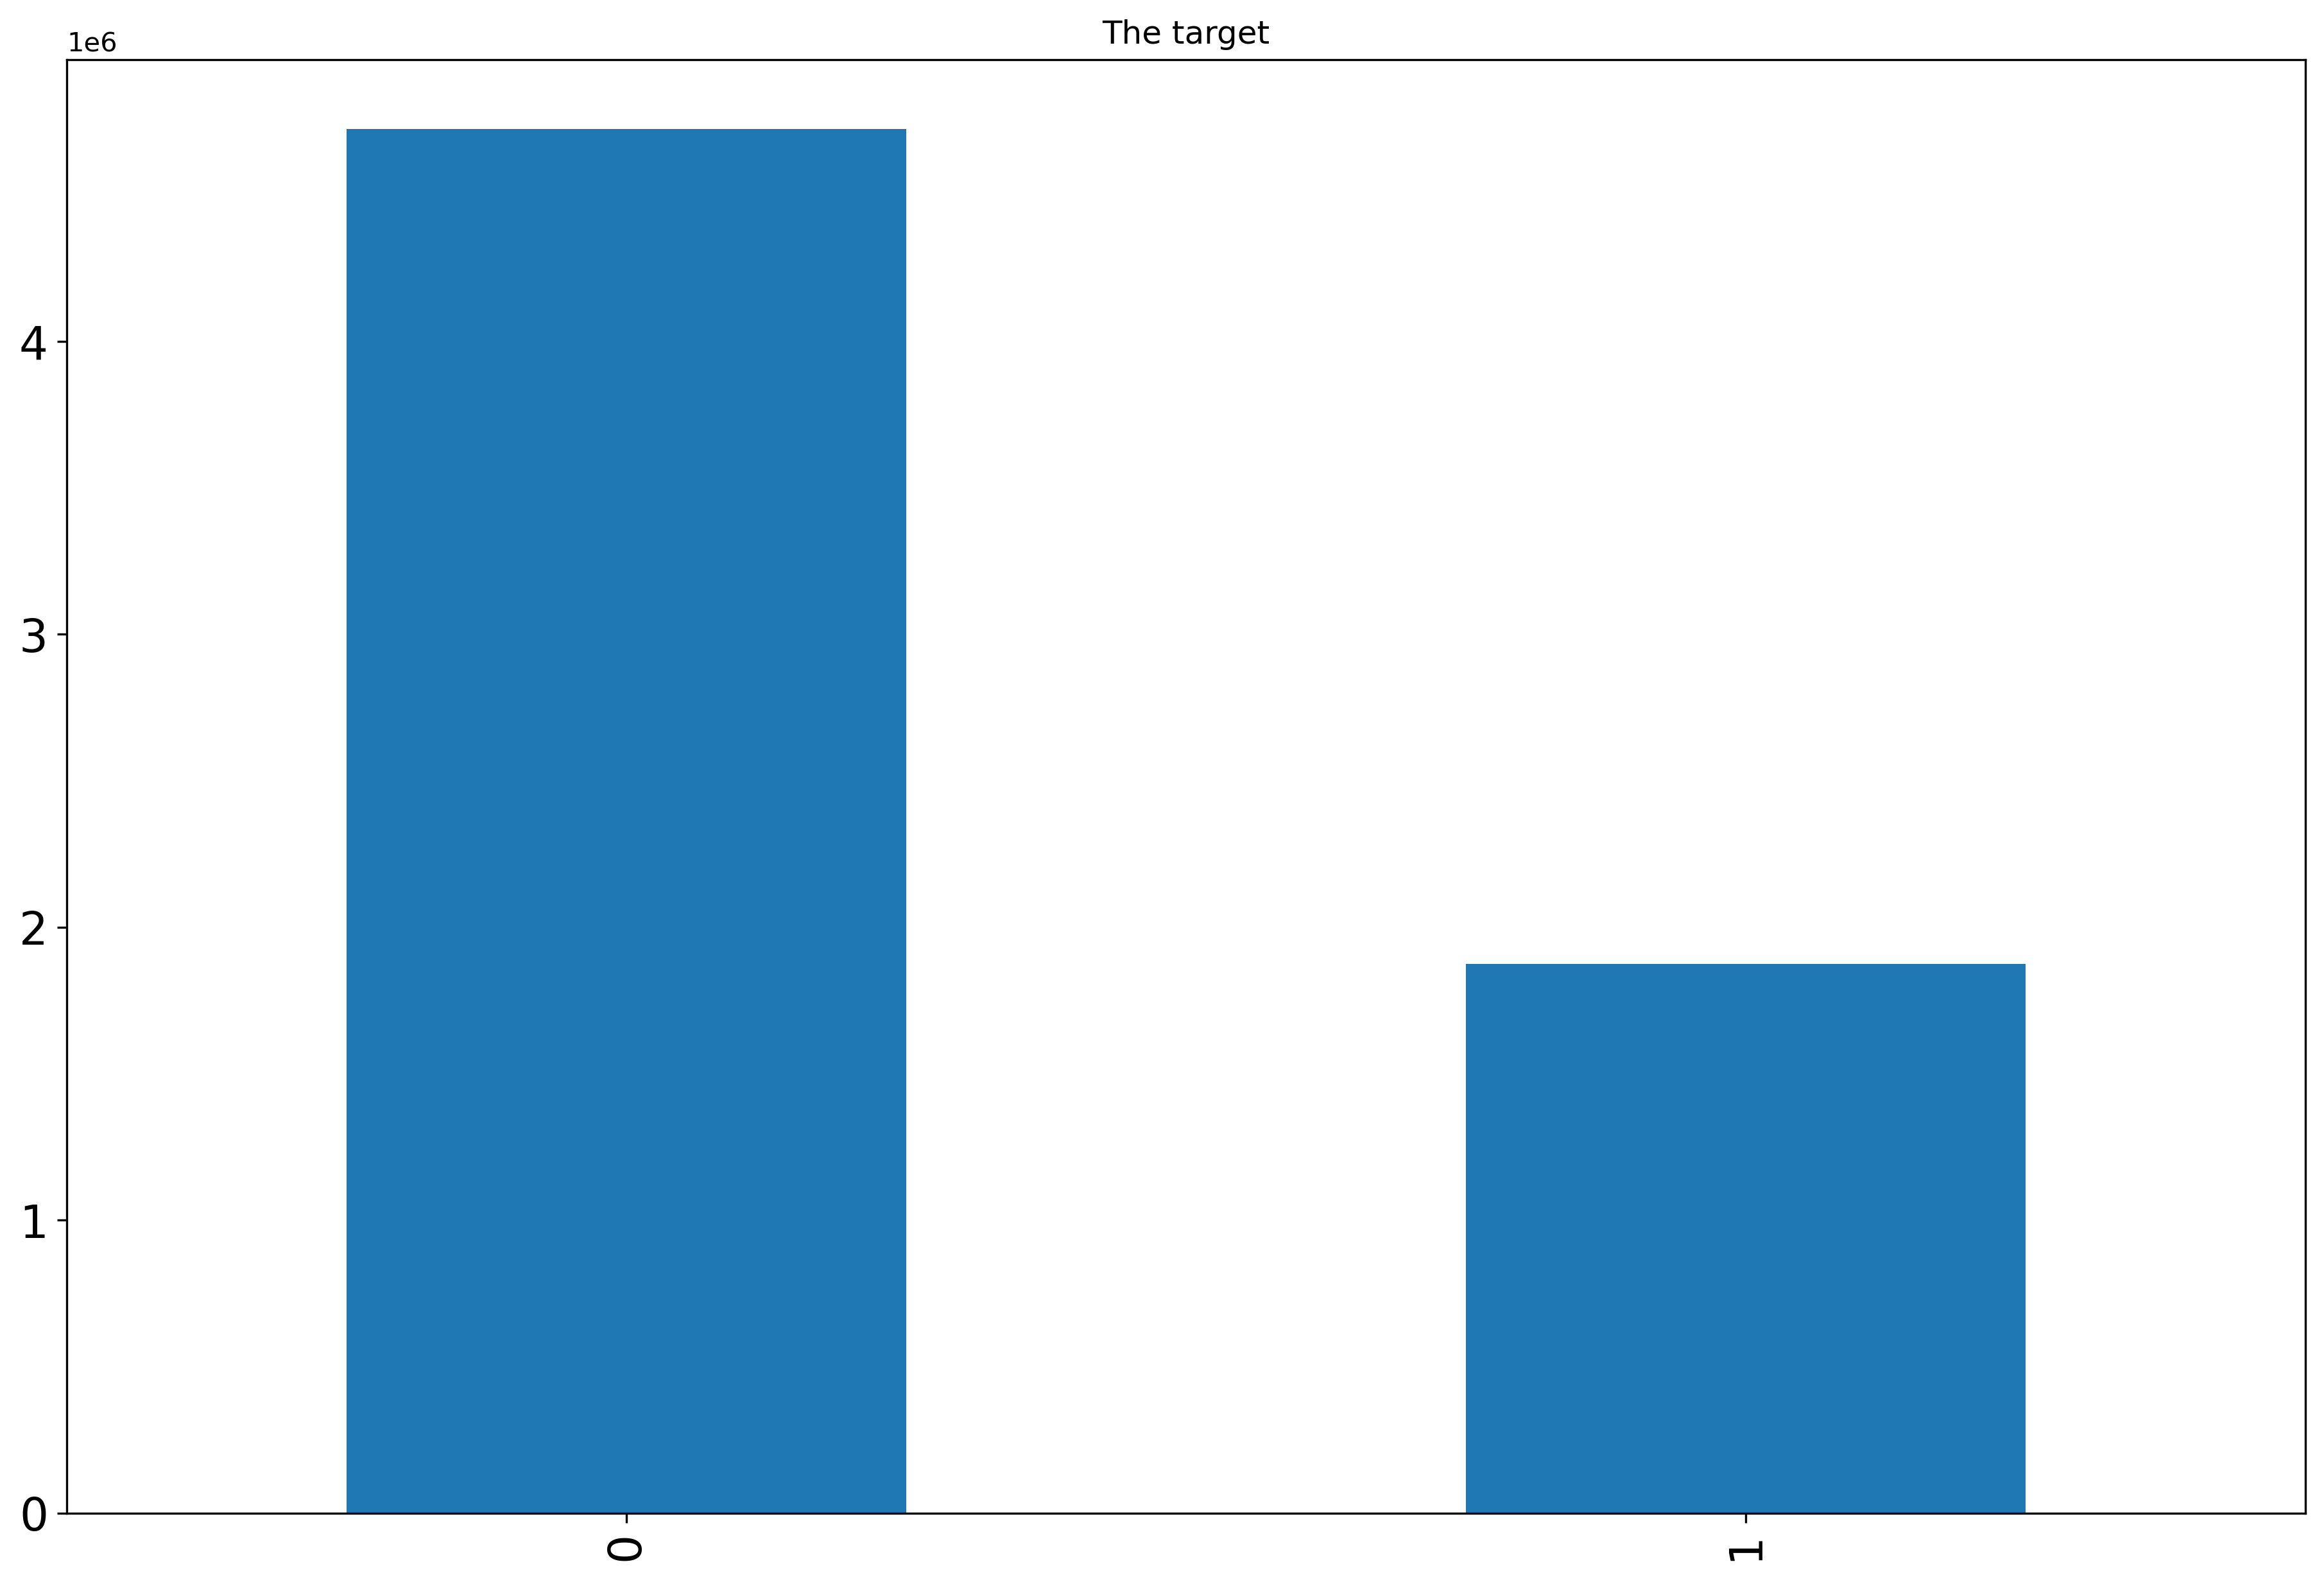

In [39]:
y.value_counts().plot(kind='bar',figsize=(15,10), 
                                title='The target',
                                fontsize=17,);
plt.gcf().set_dpi(300)
plt.savefig('imgs/classification_target.png', dpi=300)

As the first attempt, we try `LogisticRegression` from `xgboost` library. 

In [27]:
clf = LogisticRegression(verbose=1, solver='lbfgs', max_iter=300)
clf.fit(x_train,y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          177     M =           10

At X0         0 variables are exactly at the bounds


 This problem is unconstrained.



At iterate    0    f=  3.20237D+06    |proj g|=  1.67860D+08

At iterate   50    f=  2.13099D+06    |proj g|=  8.54186D+07

At iterate  100    f=  1.88509D+06    |proj g|=  1.10717D+06

At iterate  150    f=  1.78408D+06    |proj g|=  2.17557D+06

At iterate  200    f=  1.77113D+06    |proj g|=  2.29282D+06

At iterate  250    f=  1.76859D+06    |proj g|=  3.46020D+05

At iterate  300    f=  1.75540D+06    |proj g|=  3.36455D+06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  177    300    342      1     0     0   3.365D+06   1.755D+06
  F =   1755403.7314373644     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT       

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  8.6min finished


LogisticRegression(max_iter=300, verbose=1)

In [28]:
clf.score(x_test,y_test)

0.8359686629111452

In [36]:
pickle.dump(clf, open('xgboost_classifier', 'wb'))

In [30]:
y_pred = clf.predict(x_test)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.86      0.92      0.89   1418755
           1       0.76      0.62      0.68    561263

    accuracy                           0.84   1980018
   macro avg       0.81      0.77      0.79   1980018
weighted avg       0.83      0.84      0.83   1980018



In [30]:
model = Sequential()
model.add(Dense(50, activation='relu', input_dim=x_train.shape[1]))
model.add(Dense(20, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
model.fit(x_train,y_train, epochs=20, batch_size=2048, validation_split=0.2)        

2022-03-03 11:58:15.884074: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-03-03 11:58:16.254240: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 11482 MB memory:  -> device: 0, name: GeForce GTX TITAN X, pci bus id: 0000:02:00.0, compute capability: 5.2
2022-03-03 11:58:21.511589: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 5204011648 exceeds 10% of free system memory.
2022-03-03 11:58:25.447194: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 5204011648 exceeds 10% of free system memory.


Epoch 1/20
1805/1805 [==============================] - 9s 5ms/step - loss: 0.4730 - acc: 0.8250 - val_loss: 0.3632 - val_acc: 0.8426
Epoch 2/20
1805/1805 [==============================] - 6s 3ms/step - loss: 0.3614 - acc: 0.8422 - val_loss: 0.3569 - val_acc: 0.8446
Epoch 3/20
1805/1805 [==============================] - 6s 3ms/step - loss: 0.3583 - acc: 0.8432 - val_loss: 0.3574 - val_acc: 0.8443
Epoch 4/20
1805/1805 [==============================] - 6s 3ms/step - loss: 0.3561 - acc: 0.8443 - val_loss: 0.3534 - val_acc: 0.8459
Epoch 5/20
1805/1805 [==============================] - 6s 3ms/step - loss: 0.3539 - acc: 0.8453 - val_loss: 0.3523 - val_acc: 0.8467
Epoch 6/20
1805/1805 [==============================] - 6s 3ms/step - loss: 0.3528 - acc: 0.8457 - val_loss: 0.3513 - val_acc: 0.8470
Epoch 7/20
1805/1805 [==============================] - 6s 3ms/step - loss: 0.3520 - acc: 0.8461 - val_loss: 0.3515 - val_acc: 0.8465
Epoch 8/20
1805/1805 [==============================] - 6s 3ms

In [35]:
y_pred = model.predict(x_test)
print(classification_report(y_test,y_pred > 0.5))

2022-03-03 12:05:17.372578: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 2787865344 exceeds 10% of free system memory.


              precision    recall  f1-score   support

           0       0.88      0.92      0.90   1417804
           1       0.77      0.68      0.72    562214

    accuracy                           0.85   1980018
   macro avg       0.82      0.80      0.81   1980018
weighted avg       0.85      0.85      0.85   1980018



In [41]:
model.save('classification_model_keras')

2022-03-03 12:14:19.707465: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: classification_model_keras/assets


The neural network model achieves 84% accuracy which is slightly higher than the one achieved by xgboost. However, we still can improve this results by modifying the was the categorical columns are encoded. 

### Work directly with categorical data

In this part, we avoid changing the data types from `object` to `numeric`  and directly work with categorical data. However, as we noticed previously, one hot encoding is also not a very good option to encode categorical data due to complexity issue. Also, when using one hot encoding the encoded features are all orthogonal to each other which is far from being accurate. For this reason, we use a deep learning approach to learn an embedding for each categorical column which best fits its representation. The purpose of this embedding is to represent each category in the columns with object data type to a vector which best represent it for learning purpose. This is what an expert oncologist can probably do to e.g. rank different cancer stages based on how dangerous they are. 

Let's read the dataset and this time use an embedding layer to encode categorical features. 

In [91]:
# Read the dataset 
df = pd.read_csv('case_reduced_label_revised.csv')
df = df[df['Year of diagnosis']>=2004]
# df = df[df['Year of diagnosis']<=2017]

drop_columns = ['Age recode with <1 year olds', 
               'Grade Clinical (2018+)',
               'Grade Pathological (2018+)',
               'COD to site rec KM',
               'Race/ethnicity',
               'Patient ID',
               'Type of Reporting Source',
               'COD to site recode',
               ]
df.drop(columns=drop_columns,inplace=True)
# Drop the duplicate rows
df.drop_duplicates(inplace=True)
df.head()

Sex  Year of diagnosis Race recode (W, B, AI, API)  \
2  Female               2008                       White   
3  Female               2008                       White   
4    Male               2008                       White   
7    Male               2007                       White   
8    Male               2006                       White   

  Origin recode NHIA (Hispanic, Non-Hisp)  \
2                 Spanish-Hispanic-Latino   
3             Non-Spanish-Hispanic-Latino   
4             Non-Spanish-Hispanic-Latino   
7             Non-Spanish-Hispanic-Latino   
8             Non-Spanish-Hispanic-Latino   

                        Site recode ICD-O-3/WHO 2008 Behavior code ICD-O-3  \
2                              Rectosigmoid Junction             Malignant   
3  Trachea, Mediastinum and Other Respiratory Organs             Malignant   
4                               Melanoma of the Skin             Malignant   
7                                   NHL - Extranodal             Malignant   
8                               Melanoma of the Skin             Malignant   

                     Grade (thru 2017)                 Laterality  \
2  Moderately differentiated; Grade II         Not a paired  site   
3         Well differentiated; Grade I         Not a paired  site   
4                              Unknown         Not a paired  site   
7           B-cell; pre-B; B-precursor  Bilateral, single primary   
8                              Unknown  Right - origin of primary   

  Diagnostic Confirmation SEER Combined Summary Stage 2000 (2004-2017)  \
2      Positive histology             Distant site(s)/node(s) involved   
3      Positive histology                               Localized only   
4      Positive histology                               Localized only   
7      Positive histology                                Regional, NOS   
8      Positive histology                               Localized only   

  Derived AJCC Stage Group, 6th ed (2004-2015)  \
2                                           IV   
3                                           IB   
4                                           IB   
7                                         IIEB   
8                                          IIC   

  Derived AJCC T, 6th ed (2004-2015) Derived AJCC N, 6th ed (2004-2015)  \
2                                 T3                                 N1   
3                                T2b                                 N0   
4                                T2a                                 N0   
7                                NaN                                NaN   
8                                T4b                                 N0   

  Derived AJCC M, 6th ed (2004-2015) Reason no cancer-directed surgery  \
2                                 M1                 Surgery performed   
3                                 M0                 Surgery performed   
4                                 M0                 Surgery performed   
7                                NaN                   Not recommended   
8                                 M0                 Surgery performed   

        RX Summ--Scope Reg LN Sur (2003+) RX Summ--Surg Oth Reg/Dis (2003+)  \
2  4 or more regional lymph nodes removed        None; diagnosed at autopsy   
3                                    None        None; diagnosed at autopsy   
4                                    None        None; diagnosed at autopsy   
7                                    None        None; diagnosed at autopsy   
8              Sentinel lymph node biopsy        None; diagnosed at autopsy   

  CS tumor size (2004-2015) CS extension (2004-2015)  \
2                       035                      400   
3                       090                      100   
4                       999                      400   
7                       988                      210   
8                       055                      200   

  SEER cause-specific death classifi

In [92]:
df.replace('Blank(s)',np.nan,inplace=True)
df.replace('Recode not available',np.nan,inplace=True)
df.replace('UNK Stage',np.nan,inplace=True)

We still need to change some columns to numeric. 

In [93]:
df['Year of diagnosis'] = pd.to_numeric(df['Year of diagnosis'],errors='coerce')
df['Total number of in situ/malignant tumors for patient'] = \
            pd.to_numeric(df['Total number of in situ/malignant tumors for patient'],errors='coerce')

df['Total number of benign/borderline tumors for patient'] = \
            pd.to_numeric(df['Total number of benign/borderline tumors for patient'],errors='coerce')

In [94]:
# for some reasons Keras does not like strange characters such as +, / in the input names. For this reason, we have to change
# column names 
df.columns = [col_name.replace(' ', '_').replace('+','').replace(',','')\
                .replace('(', '').replace(')','').replace('/', '_').replace('-', '_') for col_name in df.columns]
df.columns

Index(['Sex', 'Year_of_diagnosis', 'Race_recode_W_B_AI_API',
       'Origin_recode_NHIA_Hispanic_Non_Hisp', 'Site_recode_ICD_O_3_WHO_2008',
       'Behavior_code_ICD_O_3', 'Grade_thru_2017', 'Laterality',
       'Diagnostic_Confirmation', 'SEER_Combined_Summary_Stage_2000_2004_2017',
       'Derived_AJCC_Stage_Group_6th_ed_2004_2015',
       'Derived_AJCC_T_6th_ed_2004_2015', 'Derived_AJCC_N_6th_ed_2004_2015',
       'Derived_AJCC_M_6th_ed_2004_2015', 'Reason_no_cancer_directed_surgery',
       'RX_Summ__Scope_Reg_LN_Sur_2003', 'RX_Summ__Surg_Oth_Reg_Dis_2003',
       'CS_tumor_size_2004_2015', 'CS_extension_2004_2015',
       'SEER_cause_specific_death_classification', 'Survival_months',
       'Survival_months_flag', 'Vital_status_recode_study_cutoff_used',
       'Total_number_of_in_situ_malignant_tumors_for_patient',
       'Total_number_of_benign_borderline_tumors_for_patient',
       'First_malignant_primary_indicator',
       'Age_recode_with_single_ages_and_85',
       'Median_

In [95]:
relevant_cols = [
                 'Sex',
                 'Site_recode_ICD_O_3_WHO_2008',
                 'Behavior_code_ICD_O_3',
                 'Laterality', 
                 'Reason_no_cancer_directed_surgery', 
                 'SEER_Combined_Summary_Stage_2000_2004_2017',
                 'Regional_nodes_examined_1988',
                 'Regional_nodes_positive_1988', 
                 'CS_tumor_size_2004_2015',
                 'CS_extension_2004_2015', 
                 'Total_number_of_in_situ_malignant_tumors_for_patient',
                 'Total_number_of_benign_borderline_tumors_for_patient',
                 'First_malignant_primary_indicator',
                 'Age_recode_with_single_ages_and_85', 
                 'SEER_cause_specific_death_classification',
                 'Median_household_income_inflation_adj_to_2019',
                 'Rural_Urban_Continuum_Code',
                 'Diagnostic_Confirmation',
                 'Derived_AJCC_Stage_Group_6th_ed_2004_2015',
                 'Derived_AJCC_T_6th_ed_2004_2015',
                 'Derived_AJCC_N_6th_ed_2004_2015',
                 'Derived_AJCC_M_6th_ed_2004_2015',
                 'RX_Summ__Scope_Reg_LN_Sur_2003',
                 'RX_Summ__Surg_Oth_Reg_Dis_2003',
                 'Grade_thru_2017',
                ]

The following function prepares the data for learning purpose. What we do is that we first drop rows with missing values. Next, we remove `N/A not seq 0-59` and `Dead (missing/unknown COD)` from the target column. The target column is encoded as 0 and 1. The categorical columns are encoded using `LabelEncoder`. In fact what `LabelEncoder` does is to encode the categorical columns and assign a unique integer value to each category. 

In [96]:
def prepar_data(df, relevant_cols):
    '''
    INPUT
    df - pandas dataframe 
    relevant_cols - list of relevant columns
    
    OUTPUT
    X - the modified dataframe which contains feature columns
    y - the encoded target 
    categorical_cols - the list of categorical column in the dataframe 
    numerical_cols - the list of numerical column in the dataframe 
    
    
    This function selects the relevant columns from df and does some manupulation to generate the 
    label y. It also removes y from df and then extracts the categorical and numerical features from the 
    dataframe and encodes the categorical feature (replace them with integer values). The resulting datafram is 
    exported as X
    '''

    df.dropna(inplace=True)
    
    df = df[(df['SEER_cause_specific_death_classification'] != 'N/A not seq 0-59') & 
        (df['SEER_cause_specific_death_classification'] != 'Dead (missing/unknown COD)')]
    y = df['SEER_cause_specific_death_classification']
    y[y == 'Dead (attributable to this cancer dx)'] = 1
    y[y == 'Alive or dead of other cause'] = 0
    y = pd.to_numeric(y)
    
    # exclude columns which are not in relevant_cols
    df = df[relevant_cols].drop(columns=['SEER_cause_specific_death_classification'])
        
    
    categorical_cols = df.select_dtypes('object').columns
    numerical_cols = df.select_dtypes('number').columns
    for col in categorical_cols:
        encoder = LabelEncoder()
        df[col] = encoder.fit_transform(df[col])
    X = df
    
    return X, y, categorical_cols, numerical_cols    

In [97]:
x_train, y_train, categorical_features, num_features = prepar_data(df, relevant_cols)

In [49]:
x_train.columns

Index(['Sex', 'Site_recode_ICD_O_3_WHO_2008', 'Behavior_code_ICD_O_3',
       'Laterality', 'Reason_no_cancer_directed_surgery',
       'SEER_Combined_Summary_Stage_2000_2004_2017',
       'Regional_nodes_examined_1988', 'Regional_nodes_positive_1988',
       'CS_tumor_size_2004_2015', 'CS_extension_2004_2015',
       'Total_number_of_in_situ_malignant_tumors_for_patient',
       'Total_number_of_benign_borderline_tumors_for_patient',
       'First_malignant_primary_indicator',
       'Age_recode_with_single_ages_and_85',
       'Median_household_income_inflation_adj_to_2019',
       'Rural_Urban_Continuum_Code', 'Diagnostic_Confirmation',
       'Derived_AJCC_Stage_Group_6th_ed_2004_2015',
       'Derived_AJCC_T_6th_ed_2004_2015', 'Derived_AJCC_N_6th_ed_2004_2015',
       'Derived_AJCC_M_6th_ed_2004_2015', 'RX_Summ__Scope_Reg_LN_Sur_2003',
       'RX_Summ__Surg_Oth_Reg_Dis_2003', 'Grade_thru_2017'],
      dtype='object')

In [113]:
x_train.head()

Sex  Site_recode_ICD_O_3_WHO_2008  Behavior_code_ICD_O_3  Laterality  \
2    0                            60                      1           2   
3    0                            73                      1           2   
4    1                            34                      1           2   
8    1                            34                      1           6   
9    0                            14                      1           2   

   Reason_no_cancer_directed_surgery  \
2                                  6   
3                                  6   
4                                  6   
8                                  6   
9                                  6   

   SEER_Combined_Summary_Stage_2000_2004_2017  Regional_nodes_examined_1988  \
2                                           1                             8   
3                                           3                             0   
4                                           3                             0   
8                                           3                             0   
9                                           5                             1   

   Regional_nodes_positive_1988  CS_tumor_size_2004_2015  \
2                             1                       35   
3                            98                       90   
4                            98                      591   
8                            98                       55   
9                             0                      591   

   CS_extension_2004_2015  \
2                      69   
3                       7   
4                      69   
8                      28   
9                     138   

   Total_number_of_in_situ_malignant_tumors_for_patient  \
2                                                2.0      
3                                                2.0      
4                                                2.0      
8                                                2.0      
9                                                2.0      

   Total_number_of_benign_borderline_tumors_for_patient  \
2                                                0.0      
3                                                0.0      
4                                                0.0      
8                                                0.0      
9                                                0.0      

   First_malignant_primary_indicator  Age_recode_with_single_ages_and_85  \
2                                  0                                  39   
3                                  0                                  63   
4                                  0                                  85   
8                                  0                                  81   
9                                  0                                  68   

   Median_household_income_inflation_adj_to_2019  Rural_Urban_Continuum_Code  \
2                                              8                           0   
3                                              8                           0   
4                                              8                           0   
8                                              8                           0   
9                                              8                           0   

   Diagnostic_Confirmation  Derived_AJCC_Stage_Group_6th_ed_2004_2015  \
2                        4                                         24   
3                        4                                          8   
4                        4                                          8   
8                        4                                         15   
9                        4                                         17   

   Derived_AJCC_T_6th_ed_2004_2015  Derived_AJCC_N_6th_ed_2004_2015  \
2                               19                                6   
3                               17                                1   


We know create a network which has two pipelines: 
1. A pipeline to handle numerical data
2. A pipeline to handle numerical data

[This post](https://www.kaggle.com/lucamassaron/categorical-feature-encoding-with-tensorflow) was useful for me to create this topology. 

The pipeline to handle numerical features is pretty standard. We first create inputs followed by a `BatchNormalization` and `Dropout` layers. 

The interesting part is the categorical pipeline. We first create an input for each categorical feature and then add an `Embedding` layer. The embedding layer converts the input integers (remember that we encoded categorical features as integer numbers) into vectors of appropriate size. The size of the vector is defined in the embedding layer. The embedding layer tries to understand the relationship between different categories in each categorical column of the dataframe. Next, all the layers are flattened and concatenated in `Flatten` and `concatenate` layers respectively. The network is then followed by a number of dense layers which are accompanied by `Dropout` and  `BatchNormalization` layers. The very last layer contains a `'sigmoid'` activation which is used for binary classification. 

In [100]:
def create_nn_model(df, numeric_variables, categorical_variables, dropout_ratio, 
                    hiden_layers, activation_type, optimizer_name):
    '''
    INPUT
    df - pandas dataframe 
    numeric_variables - list of numerical features in df
    categorical_variables - list of categorical features in df
    dropout_ratio - dropout ratio of dropout layers
    hiden_layers -  a list defining the depth of hidden layers in the regression part
    activation_type - activation of hidden layer
    
    OUTPUT
    model - the generated neural network model
    
    
    This function constructs the architecture of the neural network used in for classification problem. 
    It basically adds embeddinglayers for the categorical features and contanicates them with the 
    numerical features. At the end, it adds a bunch of dense layers folloed by the last layer with sigmoid activation.
    '''

    
    # Numeric inputs pipeline
    numerical_inputs = []
    numerical_feature = []
    for num_col in numeric_variables:
        numerical_inputs.append(Input(shape=[1], name=num_col))
        numerical_normalization = BatchNormalization()(numerical_inputs[-1])
        numerical_feature.append(Dropout(dropout_ratio)(numerical_normalization))
    numerical_logits = concatenate([Flatten()(num_feat) for num_feat in numerical_feature])

    # Categorical inputs pipeline
    categorical_inputs = []
    categorical_embeddings = []
    for category in categorical_variables:
        categorical_inputs.append(Input(shape=[1], name=category))
        category_counts =  df[category].nunique()
        categorical_embeddings.append(
            Embedding(category_counts+1, 
                      min(int(category_counts/1.5 + 1), 2000))(categorical_inputs[-1]))
    categorical_logits = concatenate([Flatten()(SpatialDropout1D(dropout_ratio)(cat_emb)) 
                                                                 for cat_emb in categorical_embeddings])
    
    # Fully connected layers
    x = concatenate([numerical_logits, categorical_logits])
    x = BatchNormalization()(x)
    
    for depth_of_layer in hiden_layers:
        x = Dense(depth_of_layer, activation=activation_type)(x)
        x = Dropout(dropout_ratio)(x)
        x = BatchNormalization()(x)
    
    # final activation
    output = Dense(1, activation='sigmoid')(x)
    
    model = Model(numerical_inputs + categorical_inputs, output)
    model.compile(optimizer=optimizer_name, loss='binary_crossentropy', metrics=['acc'])
    
    return model

model = create_nn_model(df=df, 
                        numeric_variables=num_features, 
                        categorical_variables=categorical_features, 
                        dropout_ratio=0.4, 
                        hiden_layers = [10, 5], 
                        activation_type='relu',
                        optimizer_name='adam')


input_names = model.input_names
input_dict = {}
for input_name in input_names:
    input_dict[input_name] = x_train[input_name].values

Let us have a look at the network topology through model summary its plot. Make sure to download it to have a close look.  

In [116]:
model.summary()

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Regional_nodes_examined_1988 (  [(None, 1)]         0           []                               
 InputLayer)                                                                                      
                                                                                                  
 Regional_nodes_positive_1988 (  [(None, 1)]         0           []                               
 InputLayer)                                                                                      
                                                                                                  
 Total_number_of_in_situ_malign  [(None, 1)]         0           []                               
 ant_tumors_for_patient (InputL                                                             

In [14]:
plot_model(model, dpi=400, to_file="classification_model.png")

In [101]:
model.fit(input_dict, y_train, epochs=20, batch_size=2048, validation_split=0.2)

Epoch 1/20
1612/1612 [==============================] - 23s 12ms/step - loss: 0.4192 - acc: 0.8132 - val_loss: 0.3343 - val_acc: 0.8613
Epoch 2/20
1612/1612 [==============================] - 19s 12ms/step - loss: 0.3888 - acc: 0.8329 - val_loss: 0.3340 - val_acc: 0.8619
Epoch 3/20
1612/1612 [==============================] - 19s 12ms/step - loss: 0.3875 - acc: 0.8333 - val_loss: 0.3338 - val_acc: 0.8617
Epoch 4/20
1612/1612 [==============================] - 20s 12ms/step - loss: 0.3871 - acc: 0.8328 - val_loss: 0.3342 - val_acc: 0.8619
Epoch 5/20
1612/1612 [==============================] - 19s 12ms/step - loss: 0.3871 - acc: 0.8326 - val_loss: 0.3340 - val_acc: 0.8618
Epoch 6/20
1612/1612 [==============================] - 20s 12ms/step - loss: 0.3866 - acc: 0.8329 - val_loss: 0.3342 - val_acc: 0.8620
Epoch 7/20
1612/1612 [==============================] - 20s 12ms/step - loss: 0.3866 - acc: 0.8327 - val_loss: 0.3332 - val_acc: 0.8623
Epoch 8/20
1612/1612 [==========================

In [102]:
_, x_test, _, y_test=train_test_split(x_train,y_train,test_size=0.5) # split the data set into test and train
input_dict = {}
for input_name in input_names:
    input_dict[input_name] = x_test[input_name].values

In [103]:
y_pred = model.predict(input_dict, batch_size=2048)
print(classification_report(y_test,y_pred > 0.5))

              precision    recall  f1-score   support

           0       0.89      0.92      0.91   1468113
           1       0.79      0.72      0.76    594294

    accuracy                           0.86   2062407
   macro avg       0.84      0.82      0.83   2062407
weighted avg       0.86      0.86      0.86   2062407



The learned network achieves a better accuracy compared to what we got in the previous section with one hot encoding. However, we still might be able to improve the results by tuning hyper parameters such as network configuration, optimisation algorithm, etc. For this reason, we use a K-Fold Cross-Validation strategy to evaluate the performance of each network. 

It is worth mentioning that we tried `KerasClassifier` wrapper from tensorflow library (as well as the one from [scikeras](https://www.adriangb.com/scikeras/stable/generated/scikeras.wrappers.KerasClassifier.html) ) so to use `GridSearchCV` from scikit learn to tune the network and leads to some strange errors in tensorflow. However, it seems this combination does not work for our case. Then, we manually generate different networks and use K-Fold cross validation to tune its performance. 

In [9]:
n_splits = 3
kfold = StratifiedKFold(n_splits=3, shuffle=True)

params = {'optimizer_name': ['adam', 'sgd'],
          'hiden_layers': [[3,2,1], [3,3,3], [10,5], [20,10], [100,50,20]],
          'dropout_ratio': [0.2, 0.5, 0.8],
          'epochs' : [10, 20, 50]
         }
cv_score_hist = {key:[] for key in params.keys()}
cv_score_hist['score'] = []

total_fits = n_splits
fits_counter = 1
for key, value in params.items():
    total_fits = total_fits * len(value)
print(f'Total number of fits: {total_fits}')
 
    
for opt_name in params['optimizer_name']:
    for hid_layer in params['hiden_layers']:
        for drop_ratio in params['dropout_ratio']:
            for epochs in params['epochs']:
                cv_score = []
                print('+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++\n')
                print(f'Running cross validation with parameters: \n optimizer_name: {opt_name}\n hiden_layers: {hid_layer}\n dropout_ratio: {drop_ratio}\n number of epochs {epochs}')
                model = create_nn_model(df=df, 
                                    numeric_variables=num_features, 
                                    categorical_variables=categorical_features, 
                                    dropout_ratio=drop_ratio, 
                                    hiden_layers = hid_layer, 
                                    activation_type='relu',
                                    optimizer_name=opt_name)
                for train, test in kfold.split(x_train, y_train):
                    input_names = model.input_names
                    input_dict = {}
                    for input_name in input_names:
                        input_dict[input_name] = x_train.iloc[train][input_name].values

                    model.fit(input_dict,y_train.iloc[train],epochs=epochs,batch_size=1024, verbose=0)
                    for input_name in input_names:
                        input_dict[input_name] = x_train.iloc[test][input_name].values
                    score = model.evaluate(input_dict,y_train.iloc[test], batch_size=1024)[1]
                    cv_score.append(score)
                    print(f'\nfinished fit {fits_counter} out of {total_fits}\n')
                    fits_counter += 1
                print(f'The average score for the set of parameters is {np.mean(cv_score)}')
                cv_score_hist['optimizer_name'].append(opt_name)
                cv_score_hist['hiden_layers'].append(hid_layer)
                cv_score_hist['dropout_ratio'].append(drop_ratio)
                cv_score_hist['epochs'].append(epochs)
                cv_score_hist['score'].append(np.mean(cv_score))
                
                
                print(score)

Total number of fits: 270
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

Running cross validation with parameters: 
 optimizer_name: adam
 hiden_layers: [3, 2, 1]
 dropout_ratio: 0.2
 number of epochs 10
1937/1937 [==============================] - 6s 3ms/step - loss: 0.3998 - acc: 0.7283

finished fit 1 out of 270

1937/1937 [==============================] - 6s 3ms/step - loss: 0.3996 - acc: 0.7283

finished fit 2 out of 270

1937/1937 [==============================] - 6s 3ms/step - loss: 0.3991 - acc: 0.7283

finished fit 3 out of 270

The average score for the set of parameters is 0.7282775640487671
0.7282778024673462
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

Running cross validation with parameters: 
 optimizer_name: adam
 hiden_layers: [3, 2, 1]
 dropout_ratio: 0.2
 number of epochs 20
1937/1937 [==============================] - 6s 3ms/step - loss: 0.4065 - acc: 0.8284

fini

1937/1937 [==============================] - 6s 3ms/step - loss: 0.4450 - acc: 0.7283

finished fit 75 out of 270

The average score for the set of parameters is 0.7282775640487671
0.7282778024673462
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

Running cross validation with parameters: 
 optimizer_name: adam
 hiden_layers: [10, 5]
 dropout_ratio: 0.8
 number of epochs 20
1937/1937 [==============================] - 6s 3ms/step - loss: 0.4457 - acc: 0.7297

finished fit 76 out of 270

1937/1937 [==============================] - 6s 3ms/step - loss: 0.4426 - acc: 0.7311

finished fit 77 out of 270

1937/1937 [==============================] - 6s 3ms/step - loss: 0.4480 - acc: 0.7295

finished fit 78 out of 270

The average score for the set of parameters is 0.7301088571548462
0.72951740026474
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

Running cross validation with parameters: 
 optim

1937/1937 [==============================] - 6s 3ms/step - loss: 0.3114 - acc: 0.8678

finished fit 112 out of 270

1937/1937 [==============================] - 6s 3ms/step - loss: 0.3112 - acc: 0.8677

finished fit 113 out of 270

1937/1937 [==============================] - 6s 3ms/step - loss: 0.3097 - acc: 0.8684

finished fit 114 out of 270

The average score for the set of parameters is 0.8679870963096619
0.8684128522872925
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

Running cross validation with parameters: 
 optimizer_name: adam
 hiden_layers: [100, 50, 20]
 dropout_ratio: 0.2
 number of epochs 50
1937/1937 [==============================] - 7s 3ms/step - loss: 0.3113 - acc: 0.8677

finished fit 115 out of 270

1937/1937 [==============================] - 6s 3ms/step - loss: 0.3102 - acc: 0.8682

finished fit 116 out of 270

1937/1937 [==============================] - 6s 3ms/step - loss: 0.3107 - acc: 0.8681

finished fit 117

1937/1937 [==============================] - 6s 3ms/step - loss: 0.5780 - acc: 0.7283

finished fit 187 out of 270

1937/1937 [==============================] - 6s 3ms/step - loss: 0.5719 - acc: 0.7283

finished fit 188 out of 270

1937/1937 [==============================] - 6s 3ms/step - loss: 0.5693 - acc: 0.7283

finished fit 189 out of 270

The average score for the set of parameters is 0.7282775640487671
0.7282778024673462
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

Running cross validation with parameters: 
 optimizer_name: sgd
 hiden_layers: [10, 5]
 dropout_ratio: 0.2
 number of epochs 10
1937/1937 [==============================] - 6s 3ms/step - loss: 0.3250 - acc: 0.8616

finished fit 190 out of 270

1937/1937 [==============================] - 6s 3ms/step - loss: 0.3235 - acc: 0.8623

finished fit 191 out of 270

1937/1937 [==============================] - 6s 3ms/step - loss: 0.3232 - acc: 0.8622

finished fit 192 out of

1937/1937 [==============================] - 6s 3ms/step - loss: 0.4391 - acc: 0.8134

finished fit 262 out of 270

1937/1937 [==============================] - 6s 3ms/step - loss: 0.3937 - acc: 0.8405

finished fit 263 out of 270

1937/1937 [==============================] - 6s 3ms/step - loss: 0.3815 - acc: 0.8470

finished fit 264 out of 270

The average score for the set of parameters is 0.8336718479792277
0.8470415472984314
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

Running cross validation with parameters: 
 optimizer_name: sgd
 hiden_layers: [100, 50, 20]
 dropout_ratio: 0.8
 number of epochs 20
1937/1937 [==============================] - 6s 3ms/step - loss: 0.3815 - acc: 0.8436

finished fit 265 out of 270

1937/1937 [==============================] - 6s 3ms/step - loss: 0.3685 - acc: 0.8500

finished fit 266 out of 270

1937/1937 [==============================] - 6s 3ms/step - loss: 0.3658 - acc: 0.8515

finished fit 267 

In [11]:
best_score_idx = np.argmax(cv_score_hist['score'])
best_score = cv_score_hist['score'][best_score_idx]
print(f'The best score is {best_score:.2f} which happened at run {best_score_idx}')
optimal_params = {key:value[best_score_idx] for key,value in cv_score_hist.items()}
optimal_params

The best score is 0.87 which happened at run 38


{'optimizer_name': 'adam',
 'hiden_layers': [100, 50, 20],
 'dropout_ratio': 0.2,
 'epochs': 50,
 'score': 0.8679908116658529}

Now that we have the optimal hyper parameters, we refit the network using the optimal set of parameters. 

In [64]:
tuned_model = create_nn_model(df=df, 
                    numeric_variables=num_features, 
                    categorical_variables=categorical_features, 
                    dropout_ratio=0.2,#optimal_params['dropout_ratio'], 
                    hiden_layers = [100, 50, 20],#optimal_params['hiden_layers'], 
                    activation_type='relu',
                    optimizer_name='adam')#optimal_params['optimizer_name'])
input_dict = {}
for input_name in input_names:
    input_dict[input_name] = x_train[input_name].values
tuned_model.fit(input_dict,y_train, epochs=50, batch_size=1024, verbose=0)


Now that we have the optimal model, let's save it. 

In [16]:
pickle.dump(tuned_model, open('tuned_classification_model_pickle', 'wb'))

2022-02-27 23:18:52.488808: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: ram://d6219581-e5c7-422f-a272-fa0cb6090ef3/assets


INFO:tensorflow:Assets written to: ram://d6219581-e5c7-422f-a272-fa0cb6090ef3/assets


In [17]:
tuned_model.save('tuned_classification_model_keras')

INFO:tensorflow:Assets written to: tuned_classification_model_keras/assets


INFO:tensorflow:Assets written to: tuned_classification_model_keras/assets


In [59]:
from tensorflow.keras.models import load_model
tuned_model = load_model('tuned_classification_model_keras')

In [67]:
_, x_test, _, y_test=train_test_split(x_train,y_train,test_size=0.5) # split the data set into test and train
input_dict = {}
for input_name in input_names:
    input_dict[input_name] = x_test[input_name].values

In [68]:
y_pred = tuned_model.predict(input_dict)
print(classification_report(y_test,y_pred > 0.5))

              precision    recall  f1-score   support

           0       0.89      0.93      0.91   1466879
           1       0.80      0.73      0.76    595528

    accuracy                           0.87   2062407
   macro avg       0.85      0.83      0.84   2062407
weighted avg       0.87      0.87      0.87   2062407



## Predict the number of months patient is expected to survive

In this part, we find the answer to the second question that is if we can predict the number of months the patient is expected to survive. Here, we also follow two approaches. The first one tried to change columns to numeric as much as possible and use one hot encoding for the categorical columns and the second approach is to use embedding layer for the categorical variables. 

The following function prepares the data for learning purpose. What we do is that we first select the relevant columns from the dataframe and create a label set from the column `Survival months`. We only consider patients that passed away due to the complications caused by the cancer. We then remove rows which include nan (it turns out that there are not a lot of them). The `Survival months` column is removed from the dataframe and the categorical columns are encoded using `LabelEncoder`. In fact what `LabelEncoder` does is to encode the categorical columns and assign a unique integer value to each category. 

In [26]:
relevant_cols = [
                 'Sex',
                 'Site_recode_ICD_O_3_WHO_2008',
                 'Behavior_code_ICD_O_3',
#                  'Laterality', 
#                  'Reason_no_cancer_directed_surgery', 
                 'SEER_Combined_Summary_Stage_2000_2004_2017',
                 'Regional_nodes_examined_1988',
                 'Regional_nodes_positive_1988', 
                 'CS_tumor_size_2004_2015',
                 'CS_extension_2004_2015', 
                 'Total_number_of_in_situ_malignant_tumors_for_patient',
                 'Total_number_of_benign_borderline_tumors_for_patient',
#                  'First_malignant_primary_indicator',
                 'Age_recode_with_single_ages_and_85', 
                 'SEER_cause_specific_death_classification',
                 'Survival_months',
#                  'Median_household_income_inflation_adj_to_2019',
#                  'Rural_Urban_Continuum_Code',
#                  'Diagnostic_Confirmation',
                 'Derived_AJCC_Stage_Group_6th_ed_2004_2015',
#                  'Derived_AJCC_T_6th_ed_2004_2015',
#                  'Derived_AJCC_N_6th_ed_2004_2015',
#                  'Derived_AJCC_M_6th_ed_2004_2015',
                 'RX_Summ__Scope_Reg_LN_Sur_2003',
                 'RX_Summ__Surg_Oth_Reg_Dis_2003',
                 'Grade_thru_2017',
                ]

In [34]:

def clean_data(df, columns_index):
    '''
    INPUT
    df - pandas dataframe 
    columns_index - the list of relevent columns
    
    OUTPUT
    X - A matrix holding all of the variables you want to consider when predicting the response
    y - the corresponding response vector
    
    This function cleans df using the following steps to produce X and y:
    1. Drop all the rows with no Survival months
    2. Create X as all the columns that are in columns_index
    3. Create y as the Survival months column
    4. For each numeric variable in X, fill the nan with the mean value of the column.
    5. Create dummy columns for all the categorical variables in X, drop the original columns
    '''
    
    df = df[df['Survival_months_flag'] == 'Complete dates are available and there are more than 0 days of survival']
    
    # Drop rows with missing survival months
    df = df.dropna(subset=['Survival_months'], axis=0)
    y = df['Survival_months']
    
    
    # exclude columns which are not in columns_index
#     df = df[columns_index]
    df = df[columns_index].drop(columns=['Survival_months'])
        
    # Fill numeric columns with the mean
    num_vars = df.select_dtypes(include=['float', 'int']).columns
    for col in num_vars:
        df[col].fillna((df[col].mean()), inplace=True)
        
    # Dummy the categorical variables
    cat_vars = df.select_dtypes(include=['object']).copy().columns
    for var in  cat_vars:
        # for each cat add dummy var, drop original column
        df = pd.concat([df.drop(var, axis=1), pd.get_dummies(df[var], prefix=var, \
                                                             prefix_sep='_', dummy_na=True, drop_first=False)], axis=1)
    
    X = df
    return X, y

In [35]:
X, y = clean_data(df_numeric, relevant_cols)

In [36]:
X.head()

Regional_nodes_examined_1988  Regional_nodes_positive_1988  \
2                      8.000000                      1.000000   
3                      0.000000                      1.180135   
4                      0.000000                      1.180135   
7                      3.999358                      1.180135   
8                      0.000000                      1.180135   

   CS_tumor_size_2004_2015  CS_extension_2004_2015  \
2                35.000000                   400.0   
3                90.000000                   100.0   
4               179.901737                   400.0   
7               988.000000                   210.0   
8                55.000000                   200.0   

   Total_number_of_in_situ_malignant_tumors_for_patient  \
2                                                2.0      
3                                                2.0      
4                                                2.0      
7                                                2.0      
8                                                2.0      

   Total_number_of_benign_borderline_tumors_for_patient  \
2                                                0.0      
3                                                0.0      
4                                                0.0      
7                                                0.0      
8                                                0.0      

   Age_recode_with_single_ages_and_85  Sex_Female  Sex_Male  Sex_nan  \
2                                39.0           1         0        0   
3                                63.0           1         0        0   
4                                85.0           0         1        0   
7                                69.0           0         1        0   
8                                81.0           0         1        0   

   Site_recode_ICD_O_3_WHO_2008_Acute Lymphocytic Leukemia  \
2                                                  0         
3                                                  0         
4                                                  0         
7                                                  0         
8                                                  0         

   Site_recode_ICD_O_3_WHO_2008_Acute Monocytic Leukemia  \
2                                                  0       
3                                                  0       
4                                                  0       
7                                                  0       
8                                                  0       

   Site_recode_ICD_O_3_WHO_2008_Acute Myeloid Leukemia  \
2                                                  0     
3                                                  0     
4                                                  0     
7                                                  0     
8                                                  0     

   Site_recode_ICD_O_3_WHO_2008_Aleukemic, Subleukemic and NOS  \
2                                                  0             
3                                                  0             
4                                                  0             
7                                                  0             
8                                                  0             

   Site_recode_ICD_O_3_WHO_2008_Anus, Anal Canal and Anorectum  \
2                                                  0             
3                                                  0             
4                                                  0             
7                                                  0             
8                                                  0             

   Site_recode_ICD_O_3_WHO_2008_Appendix  \
2                                      0   
3                                      0   
4                                      0   
7                                      0   
8                                      0   

  

In [37]:
X.shape

(4748414, 193)

There are 194 features (including dummy ones) extracted based on the selected columns. 

In [38]:
x_train, x_test, y_train, y_test=train_test_split(X,y,test_size=0.3) # split the data set into test and train

In [39]:
xg_reg = xgb.XGBRegressor(verbosity=1)

# xg_reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=0.4,
#              colsample_bynode=1, colsample_bytree=0.6, enable_categorical=False,
#              gamma=0, gpu_id=-1, importance_type=None,
#              interaction_constraints='', learning_rate=0.01,
#              max_delta_step=0, max_depth=20, min_child_weight=1,
#              monotone_constraints='()', n_estimators=1000, n_jobs=-1,
#              num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
#              reg_lambda=1, scale_pos_weight=1, subsample=0.9, tree_method='exact',
#              validate_parameters=1, verbosity=None)

In [40]:
xg_reg.fit(x_train.to_numpy(),y_train.values)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=12,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=1)

In [41]:
y_pred = xg_reg.predict(x_test)
print(f' The mean absolute error for the test data is {mean_squared_error(y_pred,y_test, squared=False)}')

 The mean absolute error for the test data is 33.80963756403545


Now, let's try using neural network for the regression problem. We use [Keras](https://keras.io/) library which is now a part of [Tensorflow](https://www.tensorflow.org/) for this reason. 

In [42]:
model = Sequential()
model.add(Dense(50, activation='relu', input_dim=X.shape[1]))
model.add(Dense(20, activation='relu'))
model.add(Dense(5, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_absolute_error'])
model.fit(x_train,y_train, epochs=50, batch_size=512, validation_split=0.2)        

2022-03-01 22:11:35.051401: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-03-01 22:11:35.520269: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 11483 MB memory:  -> device: 0, name: GeForce GTX TITAN X, pci bus id: 0000:02:00.0, compute capability: 5.2
2022-03-01 22:11:39.770025: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 4105667384 exceeds 10% of free system memory.
2022-03-01 22:11:42.870429: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 4105667384 exceeds 10% of free system memory.


Epoch 1/50
5194/5194 [==============================] - 14s 3ms/step - loss: 1391.0891 - mean_absolute_error: 27.8143 - val_loss: 1226.3345 - val_mean_absolute_error: 26.1159
Epoch 2/50
5194/5194 [==============================] - 11s 2ms/step - loss: 1219.8621 - mean_absolute_error: 25.9649 - val_loss: 1225.7581 - val_mean_absolute_error: 25.4717
Epoch 3/50
5194/5194 [==============================] - 11s 2ms/step - loss: 1201.5148 - mean_absolute_error: 25.7173 - val_loss: 1190.4238 - val_mean_absolute_error: 25.6067
Epoch 4/50
5194/5194 [==============================] - 11s 2ms/step - loss: 1193.2343 - mean_absolute_error: 25.5945 - val_loss: 1188.3060 - val_mean_absolute_error: 25.5942
Epoch 5/50
5194/5194 [==============================] - 11s 2ms/step - loss: 1187.1050 - mean_absolute_error: 25.4968 - val_loss: 1191.1953 - val_mean_absolute_error: 25.1520
Epoch 6/50
5194/5194 [==============================] - 11s 2ms/step - loss: 1183.0858 - mean_absolute_error: 25.4296 - val_l

The neural network achieves 24.97 mean absolute error. This value is still unacceptable. We will try to get a more accurate prediction using embedding layer. 

## Work directly with categorical data

In this part, we avoid changing the data types from `object` to `numeric`  and directly work with categorical data. However, as we noticed previously, one hot encoding is also not a very good option to encode categorical data due to complexity issue. Also, when using one hot encoding the encoded features are all orthogonal to each other which is far from being accurate. For this reason, we use a deep learning approach to learn an embedding for each categorical column which best fits its representation. The purpose of this embedding is to represent each feature in the columns with object data type to a vector which best represent it for learning purpose. This is what an expert oncologist can probably do to e.g. rank different cancer stages based on how dangerous they are. 

Let's read the dataset and this time use an embedding layer to encode categorical features. 

In [3]:
# Read the dataset 
df = pd.read_csv('case_reduced_label_revised.csv')
df = df[df['Year of diagnosis']>=2004]
# df = df[df['Year of diagnosis']<=2017]

drop_columns = ['Age recode with <1 year olds', 
               'Grade Clinical (2018+)',
               'Grade Pathological (2018+)',
               'COD to site rec KM',
               'Race/ethnicity',
               'Patient ID',
               'Type of Reporting Source',
               'COD to site recode',
               ]
df.drop(columns=drop_columns,inplace=True)
# Drop the duplicate rows
df.drop_duplicates(inplace=True)
df.head()

Sex  Year of diagnosis Race recode (W, B, AI, API)  \
2  Female               2008                       White   
3  Female               2008                       White   
4    Male               2008                       White   
7    Male               2007                       White   
8    Male               2006                       White   

  Origin recode NHIA (Hispanic, Non-Hisp)  \
2                 Spanish-Hispanic-Latino   
3             Non-Spanish-Hispanic-Latino   
4             Non-Spanish-Hispanic-Latino   
7             Non-Spanish-Hispanic-Latino   
8             Non-Spanish-Hispanic-Latino   

                        Site recode ICD-O-3/WHO 2008 Behavior code ICD-O-3  \
2                              Rectosigmoid Junction             Malignant   
3  Trachea, Mediastinum and Other Respiratory Organs             Malignant   
4                               Melanoma of the Skin             Malignant   
7                                   NHL - Extranodal             Malignant   
8                               Melanoma of the Skin             Malignant   

                     Grade (thru 2017)                 Laterality  \
2  Moderately differentiated; Grade II         Not a paired  site   
3         Well differentiated; Grade I         Not a paired  site   
4                              Unknown         Not a paired  site   
7           B-cell; pre-B; B-precursor  Bilateral, single primary   
8                              Unknown  Right - origin of primary   

  Diagnostic Confirmation SEER Combined Summary Stage 2000 (2004-2017)  \
2      Positive histology             Distant site(s)/node(s) involved   
3      Positive histology                               Localized only   
4      Positive histology                               Localized only   
7      Positive histology                                Regional, NOS   
8      Positive histology                               Localized only   

  Derived AJCC Stage Group, 6th ed (2004-2015)  \
2                                           IV   
3                                           IB   
4                                           IB   
7                                         IIEB   
8                                          IIC   

  Derived AJCC T, 6th ed (2004-2015) Derived AJCC N, 6th ed (2004-2015)  \
2                                 T3                                 N1   
3                                T2b                                 N0   
4                                T2a                                 N0   
7                                NaN                                NaN   
8                                T4b                                 N0   

  Derived AJCC M, 6th ed (2004-2015) Reason no cancer-directed surgery  \
2                                 M1                 Surgery performed   
3                                 M0                 Surgery performed   
4                                 M0                 Surgery performed   
7                                NaN                   Not recommended   
8                                 M0                 Surgery performed   

        RX Summ--Scope Reg LN Sur (2003+) RX Summ--Surg Oth Reg/Dis (2003+)  \
2  4 or more regional lymph nodes removed        None; diagnosed at autopsy   
3                                    None        None; diagnosed at autopsy   
4                                    None        None; diagnosed at autopsy   
7                                    None        None; diagnosed at autopsy   
8              Sentinel lymph node biopsy        None; diagnosed at autopsy   

  CS tumor size (2004-2015) CS extension (2004-2015)  \
2                       035                      400   
3                       090                      100   
4                       999                      400   
7                       988                      210   
8                       055                      200   

  SEER cause-specific death classifi

We still need to change `'Survival months'` column to numeric as this is what we are going to predict. 

In [4]:
df['Survival months'] = pd.to_numeric(df['Survival months'],errors='coerce')
df['Total number of in situ/malignant tumors for patient'] = \
            pd.to_numeric(df['Total number of in situ/malignant tumors for patient'],errors='coerce')

df['Total number of benign/borderline tumors for patient'] = \
            pd.to_numeric(df['Total number of benign/borderline tumors for patient'],errors='coerce')

In [5]:
# for some reasons Keras does not like strange characters such as +, / in the input names. For this reason, we have to change
# column names 
df.columns = [col_name.replace(' ', '_').replace('+','').replace(',','')\
                .replace('(', '').replace(')','').replace('/', '_').replace('-', '_') for col_name in df.columns]
df.columns

Index(['Sex', 'Year_of_diagnosis', 'Race_recode_W_B_AI_API',
       'Origin_recode_NHIA_Hispanic_Non_Hisp', 'Site_recode_ICD_O_3_WHO_2008',
       'Behavior_code_ICD_O_3', 'Grade_thru_2017', 'Laterality',
       'Diagnostic_Confirmation', 'SEER_Combined_Summary_Stage_2000_2004_2017',
       'Derived_AJCC_Stage_Group_6th_ed_2004_2015',
       'Derived_AJCC_T_6th_ed_2004_2015', 'Derived_AJCC_N_6th_ed_2004_2015',
       'Derived_AJCC_M_6th_ed_2004_2015', 'Reason_no_cancer_directed_surgery',
       'RX_Summ__Scope_Reg_LN_Sur_2003', 'RX_Summ__Surg_Oth_Reg_Dis_2003',
       'CS_tumor_size_2004_2015', 'CS_extension_2004_2015',
       'SEER_cause_specific_death_classification', 'Survival_months',
       'Survival_months_flag', 'Vital_status_recode_study_cutoff_used',
       'Total_number_of_in_situ_malignant_tumors_for_patient',
       'Total_number_of_benign_borderline_tumors_for_patient',
       'First_malignant_primary_indicator',
       'Age_recode_with_single_ages_and_85',
       'Median_

In [6]:
relevant_cols = [
                 'Sex',
                 'Site_recode_ICD_O_3_WHO_2008',
                 'Behavior_code_ICD_O_3',
                 'Laterality', 
                 'Reason_no_cancer_directed_surgery', 
                 'SEER_Combined_Summary_Stage_2000_2004_2017',
                 'Regional_nodes_examined_1988',
                 'Regional_nodes_positive_1988', 
                 'CS_tumor_size_2004_2015',
                 'CS_extension_2004_2015', 
                 'Total_number_of_in_situ_malignant_tumors_for_patient',
                 'Total_number_of_benign_borderline_tumors_for_patient',
                 'First_malignant_primary_indicator',
                 'Age_recode_with_single_ages_and_85', 
                 'SEER_cause_specific_death_classification',
                 'Median_household_income_inflation_adj_to_2019',
                 'Rural_Urban_Continuum_Code',
                 'Diagnostic_Confirmation',
                 'Survival_months',
                 'Derived_AJCC_Stage_Group_6th_ed_2004_2015',
                 'Derived_AJCC_T_6th_ed_2004_2015',
                 'Derived_AJCC_N_6th_ed_2004_2015',
                 'Derived_AJCC_M_6th_ed_2004_2015',
                 'RX_Summ__Scope_Reg_LN_Sur_2003',
                 'RX_Summ__Surg_Oth_Reg_Dis_2003',
                 'Grade_thru_2017',
                ]

The following function prepares the data for learning purpose. What we do is that we first select the relevant columns from the dataframe and only consider patients that passed away due to the complications caused by the cancer. Next, we drop rows which include a missing data and create a label set from the column `Survival months`. The `Survival months` column is removed from the dataframe and the categorical columns are encoded using `LabelEncoder`. In fact what `LabelEncoder` does is to encode the categorical columns and assign a unique integer value to each category. 

In [47]:
def prepar_data(df, relevant_cols):
    '''
    INPUT
    df - pandas dataframe 
    relevant_cols - list of relevant columns 
    
    OUTPUT
    X - the modified dataframe which contains feature columns
    y - target column
    categorical_cols - the list of categorical column in the dataframe 
    numerical_cols - the list of numerical column in the dataframe 
    
    
    This function selects the relevant columns from df and does some manupulation to generate the 
    label y. It also removes y from df and then extracts the categorical and numerical features from the 
    dataframe and encode the categorical feature (replace them with integer values). The resulting datafram is 
    exported as X
    '''

    df = df[df['Survival_months_flag'] == 'Complete dates are available and there are more than 0 days of survival'] 
    df = df[relevant_cols]

    df = df[df['SEER_cause_specific_death_classification'] == 'Dead (attributable to this cancer dx)']
    df.drop(columns=['SEER_cause_specific_death_classification'],inplace=True)
    
    
    # if you want to predict the survival months only for one type of cancer, uncomment the following two lines
#     df = df[df['Site_recode_ICD_O_3_WHO_2008'] == 'Lung and Bronchus']
#     df.drop(columns=['Site_recode_ICD_O_3_WHO_2008'], inplace=True)
    

    df.dropna(inplace=True)
    y = df['Survival_months']
    df.drop(columns=['Survival_months'], inplace=True)
    
    categorical_cols = df.select_dtypes('object').columns
    numerical_cols = df.select_dtypes('number').columns
    for col in categorical_cols:
        encoder = LabelEncoder()
        df[col] = encoder.fit_transform(df[col])
#     x_train, x_test, y_train, y_test=train_test_split(df, y, test_size=0.3)
    
#     scaler = StandardScaler()
#     scaler.fit(x_train)
#     x_train_normalized = pd.DataFrame(scaler.transform(x_train),columns = x_train.columns)
#     x_test_normalized = pd.DataFrame(scaler.transform(x_test),columns = x_test.columns)
    
    X = df
    
#     return x_train, x_test, y_train, y_test, categorical_cols, numerical_cols
    return X, y, categorical_cols, numerical_cols    

In [48]:
x_train, y_train, categorical_features, num_features = prepar_data(df, relevant_cols)

We know create a network which has two pipelines: 
1. A pipeline to handle numerical data
2. A pipeline to handle categorical data

[This post](https://www.kaggle.com/lucamassaron/categorical-feature-encoding-with-tensorflow) was useful for me to create this topology. 

The pipeline to handle numerical features is pretty standard. We first create inputs followed by a `BatchNormalization` and `Dropout` layers. 

The interesting part is the categorical pipeline. We first create an input for each categorical feature and then add an `Embedding` layer. The embedding layer converts the input integers (remember that we encoded categorical features as integer numbers) into vectors of appropriate size. The size of the vector is defined in the embedding layer. The embedding layer tries to understand the relationship between different categories in each categorical column of the dataframe. Next, all the layers are flattened and concatenated in `Flatten` and `concatenate` layers respectively. The network is then followed by a number of dense layers which are accompanied by `Dropout` and  `BatchNormalization` layers. 

In [49]:
def create_nn_model(df, numeric_variables, categorical_variables, dropout_ratio, 
                    hiden_layers, activation_type, optimizer_name):
    '''
    INPUT
    df - pandas dataframe 
    numeric_variables - list of numerical features in df
    categorical_variables - list of categorical features in df
    dropout_ratio - dropout ratio of dropout layers
    hiden_layers -  a list defining the depth of hidden layers in the regression part
    activation_type - activation of hidden layer
    
    OUTPUT
    model - the generated neural network model
    
    
    This function constructs the architecture of the neural network used in for regression problem. 
    It basically adds embeddinglayers for the categorical features and contanicates them with the 
    numerical features. At the end, it adds a bunch of dense layers for the regression problem.
    '''

    
    # Numeric inputs pipeline
    numerical_inputs = []
    numerical_feature = []
    for num_col in numeric_variables:
        numerical_inputs.append(Input(shape=[1], name=num_col))
        numerical_normalization = BatchNormalization()(numerical_inputs[-1])
        numerical_feature.append(Dropout(dropout_ratio)(numerical_normalization))
    numerical_logits = concatenate([Flatten()(num_feat) for num_feat in numerical_feature])

    # Categorical inputs pipeline
    categorical_inputs = []
    categorical_embeddings = []
    for category in categorical_variables:
        categorical_inputs.append(Input(shape=[1], name=category))
        category_counts =  df[category].nunique()
        categorical_embeddings.append(
            Embedding(category_counts+1, 
                      min(int(category_counts/1.5 + 1), 20))(categorical_inputs[-1]))
    categorical_logits = concatenate([Flatten()(SpatialDropout1D(dropout_ratio)(cat_emb)) 
                                                                 for cat_emb in categorical_embeddings])
    
    # Fully connected layers
    x = concatenate([numerical_logits, categorical_logits])
    x = BatchNormalization()(x)
    
    for depth_of_layer in hiden_layers:
        x = Dense(depth_of_layer, activation=activation_type)(x)
        x = Dropout(dropout_ratio)(x)
        x = BatchNormalization()(x)
    
    # final activation
    output = Dense(1)(x)
    
    model = Model(numerical_inputs + categorical_inputs, output)
    model.compile(optimizer=optimizer_name, loss='mean_squared_error', metrics=['mean_absolute_error'])
    
    return model

model = create_nn_model(df=df, 
                        numeric_variables=num_features, 
                        categorical_variables=categorical_features, 
                        dropout_ratio=0.3, 
                        hiden_layers = [20, 10], 
                        activation_type='relu',
                        optimizer_name='adam')


input_names = model.input_names
input_dict = {}
for input_name in input_names:
    input_dict[input_name] = x_train[input_name].values

Let us have a look at the network topology through model summary its plot. Make sure to download it to have a close look.  

In [42]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Regional_nodes_examined_1988 (  [(None, 1)]         0           []                               
 InputLayer)                                                                                      
                                                                                                  
 Regional_nodes_positive_1988 (  [(None, 1)]         0           []                               
 InputLayer)                                                                                      
                                                                                                  
 Total_number_of_in_situ_malign  [(None, 1)]         0           []                               
 ant_tumors_for_patient (InputL                                                               

In [43]:
plot_model(model, dpi=400, to_file="regression_model.png")

In [122]:
model.fit(input_dict, y_train, epochs=20, batch_size=1024, validation_split=0.2)

Epoch 1/20
924/924 [==============================] - 15s 13ms/step - loss: 672.6661 - mean_absolute_error: 15.6974 - val_loss: 371.7467 - val_mean_absolute_error: 11.6942
Epoch 2/20
924/924 [==============================] - 11s 12ms/step - loss: 433.7065 - mean_absolute_error: 13.1867 - val_loss: 330.8697 - val_mean_absolute_error: 11.8926
Epoch 3/20
924/924 [==============================] - 11s 12ms/step - loss: 423.7488 - mean_absolute_error: 13.3467 - val_loss: 330.5572 - val_mean_absolute_error: 11.9125
Epoch 4/20
924/924 [==============================] - 11s 12ms/step - loss: 423.8159 - mean_absolute_error: 13.3348 - val_loss: 330.4726 - val_mean_absolute_error: 11.9218
Epoch 5/20
924/924 [==============================] - 11s 12ms/step - loss: 422.3464 - mean_absolute_error: 13.3116 - val_loss: 330.6133 - val_mean_absolute_error: 12.0478
Epoch 6/20
924/924 [==============================] - 11s 12ms/step - loss: 422.3697 - mean_absolute_error: 13.3075 - val_loss: 329.9835 - v

The learned network achieves a much smaller mean absolute error compared to what we got in the previous section with one hot encoding. However, we still might be able to improve the results by tuning hyper parameters such as network configuration, optimisation algorithm, etc. For this reason, we use a K-Fold Cross-Validation strategy to evaluate the performance of each network. 

It is worth mentioning that we tried `KerasRegressor` wrapper from tensorflow library (as well as the one from [scikeras](https://www.adriangb.com/scikeras/stable/generated/scikeras.wrappers.KerasRegressor.html) ) so to use `GridSearchCV` from scikit learn to tune the network and leads to some strange errors in tensorflow. However, it seems this combination does not work for our case. Then, we manually generate different networks and use K-Fold cross validation to tune its performance. 

In [50]:
n_splits = 3
kfold = StratifiedKFold(n_splits=3, shuffle=True)

params = {'optimizer_name': ['adam', 'sgd'],
          'hiden_layers': [[3,2,1], [20,10], [100,50,20], [200,100,50,10]],
          'dropout_ratio': [0.1, 0.2, 0.4],
          'epochs' : [25, 50]
         }
cv_score_hist = {key:[] for key in params.keys()}
cv_score_hist['score'] = []

total_fits = n_splits
fits_counter = 1
for key, value in params.items():
    total_fits = total_fits * len(value)
print(f'Total number of fits: {total_fits}')
 
    
for opt_name in params['optimizer_name']:
    for hid_layer in params['hiden_layers']:
        for drop_ratio in params['dropout_ratio']:
            for epochs in params['epochs']:
                cv_score = []
                print('+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++\n')
                print(f'Running cross validation with parameters: \n optimizer_name: {opt_name}\n hiden_layers: {hid_layer}\n dropout_ratio: {drop_ratio}\n number of epochs {epochs}')
                model = create_nn_model(df=df, 
                                    numeric_variables=num_features, 
                                    categorical_variables=categorical_features, 
                                    dropout_ratio=drop_ratio, 
                                    hiden_layers = hid_layer, 
                                    activation_type='relu',
                                    optimizer_name=opt_name)
                for train, test in kfold.split(x_train, y_train):
                    input_names = model.input_names
                    input_dict = {}
                    for input_name in input_names:
                        input_dict[input_name] = x_train.iloc[train][input_name].values

                    model.fit(input_dict,y_train.iloc[train],epochs=epochs,batch_size=2048, verbose=0)
                    for input_name in input_names:
                        input_dict[input_name] = x_train.iloc[test][input_name].values
                    score = model.evaluate(input_dict,y_train.iloc[test], batch_size=2048)[1]
                    cv_score.append(score)
                    print(f'\nfinished fit {fits_counter} out of {total_fits}\n')
                    fits_counter += 1
                print(f'The average score for the set of parameters is {np.mean(cv_score)}')
                cv_score_hist['optimizer_name'].append(opt_name)
                cv_score_hist['hiden_layers'].append(hid_layer)
                cv_score_hist['dropout_ratio'].append(drop_ratio)
                cv_score_hist['epochs'].append(epochs)
                cv_score_hist['score'].append(np.mean(cv_score))
                
                
                print(score)

Total number of fits: 144
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

Running cross validation with parameters: 
 optimizer_name: adam
 hiden_layers: [3, 2, 1]
 dropout_ratio: 0.1
 number of epochs 25
193/193 [==============================] - 1s 3ms/step - loss: 410.1183 - mean_absolute_error: 13.3402

finished fit 1 out of 144

193/193 [==============================] - 1s 3ms/step - loss: 405.8161 - mean_absolute_error: 13.3483

finished fit 2 out of 144

193/193 [==============================] - 1s 3ms/step - loss: 407.5492 - mean_absolute_error: 13.3441

finished fit 3 out of 144

The average score for the set of parameters is 13.344216028849283
13.344144821166992
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

Running cross validation with parameters: 
 optimizer_name: adam
 hiden_layers: [3, 2, 1]
 dropout_ratio: 0.1
 number of epochs 50
193/193 [==============================]

193/193 [==============================] - 1s 3ms/step - loss: 385.2157 - mean_absolute_error: 12.6910

finished fit 70 out of 144

193/193 [==============================] - 1s 3ms/step - loss: 378.3473 - mean_absolute_error: 12.6267

finished fit 71 out of 144

193/193 [==============================] - 1s 3ms/step - loss: 379.0154 - mean_absolute_error: 12.6298

finished fit 72 out of 144

The average score for the set of parameters is 12.64914353688558
12.62979793548584
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

Running cross validation with parameters: 
 optimizer_name: sgd
 hiden_layers: [3, 2, 1]
 dropout_ratio: 0.1
 number of epochs 25
193/193 [==============================] - 1s 3ms/step - loss: 414.1559 - mean_absolute_error: 13.2448

finished fit 73 out of 144

193/193 [==============================] - 1s 3ms/step - loss: 415.5997 - mean_absolute_error: 13.3475

finished fit 74 out of 144

193/193 [=====================

193/193 [==============================] - 1s 3ms/step - loss: 395.0435 - mean_absolute_error: 12.3639

finished fit 106 out of 144

193/193 [==============================] - 1s 3ms/step - loss: 384.7154 - mean_absolute_error: 12.7127

finished fit 107 out of 144

193/193 [==============================] - 1s 3ms/step - loss: 386.6488 - mean_absolute_error: 12.7340

finished fit 108 out of 144

The average score for the set of parameters is 12.603554407755533
12.73401927947998
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

Running cross validation with parameters: 
 optimizer_name: sgd
 hiden_layers: [100, 50, 20]
 dropout_ratio: 0.1
 number of epochs 25
193/193 [==============================] - 1s 3ms/step - loss: 370.8795 - mean_absolute_error: 12.6244

finished fit 109 out of 144

193/193 [==============================] - 1s 3ms/step - loss: 368.5479 - mean_absolute_error: 12.5424

finished fit 110 out of 144

193/193 [===========

In [62]:
best_score_idx = np.argmin(cv_score_hist['score'])
best_score = cv_score_hist['score'][best_score_idx]
print(f'The best score is {best_score:.2f} which happened at run {best_score_idx}')
optimal_params = {key:value[best_score_idx] for key,value in cv_score_hist.items()}
optimal_params

The best score is 11.50 which happened at run 37


{'optimizer_name': 'sgd',
 'hiden_layers': [100, 50, 20],
 'dropout_ratio': 0.1,
 'epochs': 50,
 'score': 11.5}

Now that we have the optimal hyper parameters, we refit the network using the optimal set of parameters. 

In [52]:
tuned_model = create_nn_model(df=df, 
                    numeric_variables=num_features, 
                    categorical_variables=categorical_features, 
                    dropout_ratio=optimal_params['dropout_ratio'], 
                    hiden_layers = optimal_params['hiden_layers'], 
                    activation_type='relu',
                    optimizer_name=optimal_params['optimizer_name'])
input_dict = {}
for input_name in input_names:
    input_dict[input_name] = x_train[input_name].values
tuned_model.fit(input_dict,y_train, epochs=optimal_params['epochs'], batch_size=1024, verbose=0)


Now that we have the optimal model, let's save it. 

In [53]:
import pickle
pickle.dump(tuned_model, open('tuned_regression_model_pickle', 'wb'))

2022-03-02 10:07:56.637790: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: ram://0c3555f9-dc68-4b65-aac2-44a7c6a0b132/assets


INFO:tensorflow:Assets written to: ram://0c3555f9-dc68-4b65-aac2-44a7c6a0b132/assets


In [54]:
tuned_model.save('tuned_regression_model_keras')

INFO:tensorflow:Assets written to: tuned_regression_model_keras/assets


INFO:tensorflow:Assets written to: tuned_regression_model_keras/assets
